In [1]:
# 加载需要的库
import time
import math
import datetime
import numpy as np
import pandas as pd

import tushare as ts
import backtrader as bt
from sklearn.svm import SVR

from ast import literal_eval
import matplotlib.pyplot as plt
from backtrader.feeds import PandasData
from sklearn.preprocessing import RobustScaler

In [2]:
# 实例化支持向量回归（SVR）模型
svr = SVR()

In [3]:
# 获取已清洗好的全A股列表
stocklist_allA = pd.read_csv("Data/1-stocklist_allA.csv")
stocklist_allA = stocklist_allA["0"].tolist()

# 获取已清洗好的全A股所有数据
df_all = pd.read_csv("Data/4-allA-all_data.csv")
del df_all["datetime.1"]
df_all["datetime"] = pd.to_datetime(df_all["datetime"])

In [4]:
"""
获得某一股票的全部数据
输入：code--该股票对应的ts_code
输出：df_stock--该股票的全部数据，存为df
"""


def get_stock_data(code):
    df_stock = df_all[df_all["code"] == code]
    df_stock = df_stock[[
        "datetime",
        "open",
        "high",
        "low",
        "close",
        "volume",
        "openinterest",
        "news",
        "heat",
        "turnover_rate_f",
        "circ_mv",
        "total_mv",
    ]]
    df_stock.index = df_stock.datetime
    df_stock = df_stock.sort_index()
    return df_stock

In [5]:
# 修改原数据加载模块，以便能够加载更多自定义的因子数据
class Addmoredata(PandasData):
    lines = (
        "news",
        "heat",
        "turnover_rate_f",
        "circ_mv",
        "total_mv",
    )
    params = (
        ("news", 7),
        ("heat", 8),
        ("turnover_rate_f", 9),
        ("circ_mv", 10),
        ("total_mv", 11),
    )

In [6]:
# 设置佣金和印花税率
class stampDutyCommissionScheme(bt.CommInfoBase):
    """
    本佣金模式下，买入股票仅支付佣金，卖出股票支付佣金和印花税.
    """

    params = (
        ("stamp_duty", 0.001),  # 印花税率
        ("commission", 0.0005),  # 佣金率
        ("stocklike", True),
        ("commtype", bt.CommInfoBase.COMM_PERC),
    )

    def _getcommission(self, size, price, pseudoexec):
        """
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        """
        # print('self.p.commission',self.p.commission)
        if size > 0:  # 买入，不考虑印花税
            return size * price * self.p.commission * 100
        elif size < 0:  # 卖出，考虑印花税
            return -size * price * (self.p.stamp_duty + self.p.commission * 100)
        else:
            return 0

In [ ]:
# 编写策略
class momentum_factor_strategy(bt.Strategy):
    # interval-换仓间隔，stocknum-持仓股票数
    params = (
        ("interval", 1),
        ("stocknum", 10),
    )

    def log(self, txt, dt=None):
        """Logging function fot this strategy"""
        dt = dt or self.datas[0].datetime.date(0)
        print("{}, {}".format(dt.isoformat(), txt))

    def __init__(self):
        # 已清洗过的每日可用股票列表
        self.df_byday = pd.read_csv("Data/3-allA_valid_stocklist_byday.csv")
        # 交易天数，用于判断是否交易
        self.bar_num = 0
        # 上次交易股票的列表
        self.last = []

        # 记录以往订单，在调仓日要全部取消未成交的订单
        self.order_list = []

    def prenext(self):

        self.next()

    def next(self):
        # 记录交易日期
        self.bar_num += 1
        print("当天日期:{}".format(str(self.datas[0].datetime.date(0))))
        # 计算当日是否调仓
        if (
            self.bar_num % self.p.interval == 0
            and self.bar_num > 3 * self.p.interval
            and self.datas[0].datetime.date(0) < datetime.date(2020, 6, 25)
        ):
            # 得到当天的时间
            current_date = self.datas[0].datetime.date(0)
            print("交易日日期:{}".format(str(self.datas[0].datetime.date(0))))
            # 获得上一调仓日时间
            prev_date = self.datas[0].datetime.date(-self.p.interval)
            # 获取当日可行股票池
            stocklist = self.get_valid_list_day(current_date)
            # 获取上一调仓日可行股票池
            stocklist_p = stocklist_p = self.get_valid_list_day(prev_date)

            # 计算本期因子数据df_fac，并清洗
            df_fac = self.get_df_fac(stocklist=stocklist, prev=0)
            df_fac = df_fac.dropna(axis=0, how="any")

            # 计算上期因子数据df_faxc_p，并清洗
            df_fac_p = self.get_df_fac(stocklist=stocklist_p, prev=1)
            df_fac_p = df_fac_p.dropna(axis=0, how="any")

            # 本期因子排列命名
            df_fac.columns = [
                "code",
                "news",
                "heat",
                "momentum_value",
                "turnover_rate_f",
                "circ_mv",
                "total_mv",
            ]
            df_fac.index = df_fac.code.values

            # 上期因子排列命名
            df_fac_p.columns = [
                "code",
                "news",
                "heat",
                "momentum_value",
                "turnover_rate_f",
                "circ_mv",
                "total_mv",
            ]
            df_fac_p.index = df_fac_p.code.values

            # 舍弃X_p和Y中不同的index（股票代码）
            # 先去除X_p比Y多的index
            diffIndex = df_fac_p.index.difference(df_fac.index)
            # 删除整行
            df_fac_p = df_fac_p.drop(diffIndex, errors="ignore")
            df_fac = df_fac.drop(diffIndex, errors="ignore")

            # 然后去除Y比X_p多的index
            diffIndex = df_fac.index.difference(df_fac_p.index)
            df_fac_p = df_fac_p.drop(diffIndex, errors="ignore")
            df_fac = df_fac.drop(diffIndex, errors="ignore")

            # X_p是上一期的因子值，X是本期因子值，Y是回归目标
            X_p = df_fac_p[
                ["news", "heat", "momentum_value", "turnover_rate_f", "circ_mv"]
            ]
            X = df_fac[["news", "heat", "momentum_value", "turnover_rate_f", "circ_mv"]]
            Y = df_fac[["momentum_value"]]

            # 将因子值与Y值均进行标准化
            rbX = RobustScaler()
            X_p = rbX.fit_transform(X_p)

            rbY = RobustScaler()
            Y = rbY.fit_transform(Y)

            # 用上期因子值与本期回报率进行训练
            svr.fit(X_p, np.ravel(Y))

            # 用本期因子值预测下期回报率
            svr_pred = svr.predict(rbX.transform(X))

            a = rbY.inverse_transform(svr_pred.reshape(-1, 1))
            df_fac["pred"] = a

            # 按照预测得到的下期收益进行排序
            df_fac.sort_values(by="pred", inplace=True, ascending=False)
            # 取预测收益>0且排序靠前的stocknum只股票做多
            df_fac_pos = df_fac[df_fac["pred"] > 0]
            sort_list_pos = df_fac["code"].tolist()
            long_list = sort_list_pos[: self.p.stocknum]

            # 取预测收益<0且排序靠后的stocknum只股票做空
            df_fac_neg = df_fac[df_fac["pred"] < 0]
            sort_list_neg = df_fac_neg["code"].tolist()
            short_list = sort_list_neg[-self.p.stocknum :]

            # 取消以往所下订单（已成交的不会起作用）
            for o in self.order_list:
                self.cancel(o)
            # 重置订单列表
            self.order_list = []

            # 若上期交易股票未出现在本期交易列表中，则平仓
            for i in self.last:
                if i not in long_list and i not in short_list:
                    d = self.getdatabyname(i)
                    print("sell 平仓", d._name, self.getposition(d).size)
                    o = self.close(data=d)
                    self.order_list.append(o)  # 记录订单

            self.log("当前总市值 %.2f" % (self.broker.getvalue()))

            # 获取当前账户价值
            total_value = self.broker.getvalue()

            # 对long_list中股票做多
            if len(long_list):

                # 每只股票买入资金百分比，预留5%的资金以应付佣金和计算误差
                buypercentage = (1 - 0.05) / 2 / len(long_list)

                # 得到目标市值
                targetvalue = buypercentage * total_value

                # 依次买入
                for d in long_list:
                    data = self.getdatabyname(d)
                    # 按次日开盘价计算下单量，下单量是100的整数倍
                    size = int(abs(targetvalue / data.open[1] // 100 * 100))
                    o = self.order_target_size(data=d, target=size)
                    # 记录订单
                    self.order_list.append(o)

            # 对short_list中股票做空
            if len(short_list):

                # 每只股票做空资金百分比，预留5%的资金以应付佣金和计算误差
                buypercentage = (1 - 0.05) / 2 / len(short_list)

                # 得到目标市值
                targetvalue = buypercentage * total_value
                # 依次卖空
                for d in short_list:
                    data = self.getdatabyname(d)
                    # 按次日开盘价计算下单量，下单量是100的整数倍
                    size = int(abs(targetvalue / data.open[1] // 100 * 100))
                    o = self.order_target_size(data=d, target=-size)
                    # 记录订单
                    self.order_list.append(o)

            # 跟踪上次交易的标的
            self.last = list(set(long_list).union(set(short_list)))

    # 交易日志
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f,"
                    " Stock: %s"
                    % (
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm,
                        order.executed.size,
                        order.data._name,
                    )
                )
            else:  # Sell
                self.log(
                    "SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f,"
                    " Stock: %s"
                    % (
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm,
                        order.executed.size,
                        order.data._name,
                    )
                )

    def notify_trade(self, trade):
        if trade.isclosed:

            self.log("TRADE PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))

    # 求个股某周期因子平均值，prev为是否为前一周期（0：否，1：是）
    def get_df_fac(self, stocklist, prev=0):
        # 初始化若干个list，用于计算因子值
        # N-个股情绪因子，H-个股热度因子，TR_F-流通股换手率，CM-流通市值，TM-总市值（未使用）
        N, H, TR_F, CM, TM = [], [], [], [], []
        # 新建df_fac用于存储计算得到的因子值
        df_fac = pd.DataFrame(
            columns=[
                "code",
                "news",
                "heat",
                "momentum_value",
                "turnover_rate_f",
                "circ_mv",
                "total_mv",
            ]
        )
        for stock in stocklist:
            data = self.getdatabyname(stock)

            # 获取当期因子值的平均数
            for i in range(self.p.interval):
                if data.news[(-i - prev * self.p.interval)] != 0:
                    N.append(data.news[(-i - prev * self.p.interval)])

                if data.heat[(-i - prev * self.p.interval)] != 0:
                    H.append(data.heat[(-i - prev * self.p.interval)])
                TR_F.append(data.turnover_rate_f[(-i - prev * self.p.interval)])
                CM.append(data.circ_mv[(-i - prev * self.p.interval)])
                TM.append(data.total_mv[(-i - prev * self.p.interval)])

            # 若当期无舆情因子数据，则不返回
            if N and H:
                # 缺失数据处理--若后续数据缺失，跳过该股票
                try:
                    data.open[1]
                except IndexError:
                    print("%s后续数据缺失，跳过该股票" % (stock))
                else:
                    if data.close[0] != 0 and data.open[1] != 0:
                        # 舆情因子取最近一天的值与当期平均值之和（加大最近一天的权重）
                        N = np.mean(N) + data.news[(-prev * self.p.interval)]
                        H = np.mean(H) + data.heat[(-prev * self.p.interval)]

                    try:
                        data.open[1 + self.p.interval - prev * self.p.interval]
                    except IndexError:
                        print("%s后续数据缺失，跳过该股票" % (stock))
                    else:

                        # 计算当期动量
                        sell_ = data.open[1 + self.p.interval - prev * self.p.interval]
                        buy_ = data.open[1 - prev * self.p.interval]
                        stock_momentum = sell_ / buy_ - 1
                        # 其余因子取当期平均值
                        TR_F = np.mean(TR_F)
                        CM = np.mean(CM)
                        TM = np.mean(TM)

                        new = pd.DataFrame(
                            {
                                "code": stock,
                                "news": N,
                                "heat": H,
                                "momentum_value": stock_momentum,
                                "turnover_rate_f": TR_F,
                                "circ_mv": CM,
                                "total_mv": TM,
                            },
                            index=[1],
                        )
                        df_fac = df_fac.append(new, ignore_index=True)
            N, H, TR_F, CM, TM = [], [], [], [], []
        return df_fac

    # 获取当日可行股票池
    def get_valid_list_day(self, current_date):
        self.df_byday["Date"] = pd.to_datetime(self.df_byday["Date"])
        current_date = datetime.datetime.strptime(str(current_date), "%Y-%m-%d")
        df_day = self.df_byday[self.df_byday["Date"] == current_date]
        stocklist = literal_eval(df_day["stocklist"].tolist()[0])
        return stocklist

Starting Portfolio Value: 1000000.00
当天日期:2017-01-03
当天日期:2017-01-04
当天日期:2017-01-05
当天日期:2017-01-06
交易日日期:2017-01-06
2017-01-06, 当前总市值 1000000.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600062.SH -300
sell 平仓 600900.SH 1300
sell 平仓 601328.SH 5100
sell 平仓 600329.SH -800
sell 平仓 600998.SH -2100
sell 平仓 601166.SH 700
sell 平仓 600598.SH -1600
sell 平仓 600690.SH 100
sell 平仓 000952.SZ -1000
sell 平仓 600548.SH 2700
sell 平仓 000429.SZ -2100
sell 平仓 600196.SH 100
sell 平仓 601857.SH 4400
2017-01-10, 当前总市值 995473.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


当天日期:2017-01-12
交易日日期:2017-01-12
sell 平仓 601328.SH 5000
sell 平仓 600998.SH -2100
sell 平仓 601939.SH 5500
sell 平仓 601998.SH 5300
sell 平仓 601238.SH 1800
sell 平仓 002230.SZ -100
sell 平仓 002120.SZ -300
sell 平仓 600808.SH -8500
sell 平仓 000989.SZ -500
sell 平仓 600118.SH 0
sell 平仓 600016.SH 200
sell 平仓 601117.SH -6300
sell 平仓 601607.SH -200
2017-01-12, 当前总市值 990169.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600062.SH -300
sell 平仓 600329.SH -800
sell 平仓 002352.SZ -300
sell 平仓 600000.SH 300
sell 平仓 600216.SH -600
sell 平仓 300144.SZ -200
sell 平仓 002230.SZ -100
sell 平仓 002737.SZ -600
sell 平仓 601318.SH 500
sell 平仓 600104.SH 200
sell 平仓 600132.SH 500
sell 平仓 600015.SH 1200
sell 平仓 601818.SH 9400
sell 平仓 000952.SZ -1100
sell 平仓 600118.SH 0
sell 平仓 601225.SH 9100
sell 平仓 600036.SH 500
sell 平仓 603883.SH -1000
sell 平仓 601607.SH 200
2017-01-16, 当前总市值 1011593.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

当天日期:2017-01-18
交易日日期:2017-01-18
sell 平仓 600900.SH -1300
sell 平仓 600885.SH -500
sell 平仓 600998.SH 2100
sell 平仓 002230.SZ 200
sell 平仓 601238.SH 1700
sell 平仓 601998.SH -5300
sell 平仓 300039.SZ 500
sell 平仓 600674.SH -300
sell 平仓 600598.SH -1700
sell 平仓 000726.SZ 500
sell 平仓 600048.SH -200
sell 平仓 600660.SH 0
sell 平仓 600276.SH 0
sell 平仓 000919.SZ 1000
sell 平仓 000963.SZ 100
sell 平仓 600976.SH -500
sell 平仓 603883.SH 1000
2017-01-18, 当前总市值 991810.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 600900.SH 1300
sell 平仓 002352.SZ 300
sell 平仓 002709.SZ 400
sell 平仓 601668.SH 4500
sell 平仓 600690.SH 100
sell 平仓 600598.SH 1600
sell 平仓 600285.SH 600
2017-01-20, 当前总市值 997839.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 601288.SH 11000
sell 平仓 002352.SZ -300
sell 平仓 601939.SH -5400
sell 平仓 601988.SH 8600
sell 平仓 600028.SH 3100
sell 平仓 600598.SH -1600
sell 平仓 600118.SH 0
sell 平仓 000598.SZ 300
sell 平仓 600456.SH -900
sell 平仓 601668.SH -4400
sell 平仓 600660.SH 0
sell 平仓 600276.SH 0
sell 平仓 002155.SZ -1500
sell 平仓 601857.SH 4400
sell 平仓 600036.SH 500
sell 平仓 601398.SH 6700
sell 平仓 601336.SH 900
2017-01-24, 当前总市值 1002000.46
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

2017-02-03, SELL EXECUTED, Price: 10.94, Cost: -47051.46, Comm 70.58, Size: -4300.00, Stock: 601857.SH
2017-02-03, SELL EXECUTED, Price: 228.70, Cost: -45740.40, Comm 68.61, Size: -200.00, Stock: 600177.SH
2017-02-03, SELL EXECUTED, Price: 5.61, Cost: -46591.22, Comm 69.89, Size: -8300.00, Stock: 601988.SH
2017-02-03, SELL EXECUTED, Price: 313.66, Cost: -31365.60, Comm 47.05, Size: -100.00, Stock: 600718.SH
2017-02-03, SELL EXECUTED, Price: 174.31, Cost: -34861.56, Comm 52.29, Size: -200.00, Stock: 600771.SH
2017-02-03, SELL EXECUTED, Price: 241.71, Cost: -24170.64, Comm 36.26, Size: -100.00, Stock: 002230.SZ
2017-02-03, TRADE PROFIT, GROSS 27.27, NET -92.33
2017-02-03, TRADE PROFIT, GROSS 113.68, NET -40.87
2017-02-03, TRADE PROFIT, GROSS 591.30, NET 497.78
2017-02-03, TRADE PROFIT, GROSS 147.29, NET -8.63
2017-02-03, TRADE PROFIT, GROSS -94.00, NET -161.00
2017-02-03, TRADE PROFIT, GROSS 155.08, NET 83.20
2017-02-03, TRADE PROFIT, GROSS -756.48, NET -912.22
2017-02-03, TRADE PROFIT, 

sell 平仓 600426.SH 500
sell 平仓 600016.SH -200
sell 平仓 600036.SH -500
sell 平仓 601336.SH 900
2017-02-07, 当前总市值 991374.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 601818.SH 9100
sell 平仓 601288.SH 10900
sell 平仓 601939.SH 5300
sell 平仓 601988.SH 8400
sell 平仓 600598.SH -16600
sell 平仓 601318.SH 500
sell 平仓 002007.SZ 0
sell 平仓 600036.SH 500
2017-02-09, 当前总市值 987640.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002352.SZ 300
sell 平仓 600118.SH 0
sell 平仓 600535.SH 100
sell 平仓 600350.SH 3500
sell 平仓 002179.SZ 200
sell 平仓 600993.SH 200
sell 平仓 002120.SZ 400
sell 平仓 600718.SH 100
2017-02-13, 当前总市值 994564.29
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

当天日期:2017-02-15
交易日日期:2017-02-15
sell 平仓 600329.SH -800
sell 平仓 002644.SZ -700
sell 平仓 600000.SH 300
sell 平仓 601166.SH 700
sell 平仓 600808.SH -7300
sell 平仓 600383.SH -200
sell 平仓 600048.SH -200
sell 平仓 600016.SH 200
sell 平仓 601117.SH -5800
sell 平仓 600036.SH 500
2017-02-15, 当前总市值 990658.22
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600598.SH -1700
sell 平仓 600690.SH -100
sell 平仓 600048.SH 200
sell 平仓 002424.SZ 200
sell 平仓 600350.SH -3500
sell 平仓 600426.SH 500
sell 平仓 601117.SH 5700
2017-02-17, 当前总市值 989317.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

2017-02-22, SELL EXECUTED, Price: 5.33, Cost: 46620.82, Comm 70.29, Size: -8800.00, Stock: 601818.SH
2017-02-22, BUY EXECUTED, Price: 10.08, Cost: -156803.75, Comm 79.15, Size: 15700.00, Stock: 601328.SH
2017-02-22, SELL EXECUTED, Price: 196.09, Cost: 39344.98, Comm 58.83, Size: -200.00, Stock: 601607.SH
2017-02-22, SELL EXECUTED, Price: 9.21, Cost: 45366.50, Comm 69.10, Size: -5000.00, Stock: 601939.SH
2017-02-22, SELL EXECUTED, Price: 81.80, Cost: 40945.15, Comm 61.35, Size: -500.00, Stock: 600009.SH
2017-02-22, BUY EXECUTED, Price: 111.42, Cost: -151064.34, Comm 77.99, Size: 1400.00, Stock: 002120.SZ
2017-02-22, SELL EXECUTED, Price: 5.94, Cost: 46652.58, Comm 69.49, Size: -7800.00, Stock: 601225.SH
2017-02-22, SELL EXECUTED, Price: 319.09, Cost: 31805.60, Comm 47.86, Size: -100.00, Stock: 002304.SZ
2017-02-22, SELL EXECUTED, Price: 33.30, Cost: 46709.74, Comm 69.94, Size: -1400.00, Stock: 601601.SH
2017-02-22, SELL EXECUTED, Price: 333.28, Cost: 32721.70, Comm 49.99, Size: -100.00,

当天日期:2017-02-24
交易日日期:2017-02-24
sell 平仓 600585.SH 500
sell 平仓 601288.SH -10500
sell 平仓 601939.SH -5000
sell 平仓 600104.SH -200
sell 平仓 600132.SH 400
sell 平仓 002433.SZ 1000
sell 平仓 600015.SH 1100
sell 平仓 601818.SH 8700
sell 平仓 600118.SH 0
sell 平仓 601857.SH -4400
sell 平仓 600016.SH -200
sell 平仓 601607.SH 200
2017-02-24, 当前总市值 982170.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002714.SZ 400
sell 平仓 002230.SZ 100
sell 平仓 002737.SZ 600
sell 平仓 600276.SH 0
sell 平仓 600872.SH 200
sell 平仓 002019.SZ 100
sell 平仓 600718.SH 100
sell 平仓 002605.SZ 600
2017-02-28, 当前总市值 1003648.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600000.SH -300
sell 平仓 601939.SH -5200
sell 平仓 600535.SH -100
sell 平仓 601988.SH 8200
sell 平仓 002179.SZ 200
sell 平仓 002120.SZ 400
sell 平仓 601166.SH -700
sell 平仓 600132.SH 400
sell 平仓 002007.SZ 0
sell 平仓 600085.SH -100
sell 平仓 600048.SH -200
sell 平仓 600660.SH 0
sell 平仓 600196.SH 100
sell 平仓 600016.SH -200
sell 平仓 603883.SH -1000
2017-03-02, 当前总市值 1008625.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.com

sell 平仓 002271.SZ 100
sell 平仓 002566.SZ 1200
sell 平仓 600118.SH 0
sell 平仓 002709.SZ 300
sell 平仓 002511.SZ 800
sell 平仓 601288.SH -13500
sell 平仓 600000.SH -300
sell 平仓 601988.SH -10400
sell 平仓 601628.SH -2000
sell 平仓 601318.SH -700
sell 平仓 600718.SH 100
sell 平仓 600016.SH -300
sell 平仓 601336.SH 1000
2017-03-06, 当前总市值 1009766.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 601939.SH 5200
sell 平仓 002179.SZ -200
sell 平仓 601166.SH 700
sell 平仓 601238.SH -1600
sell 平仓 600872.SH -200
sell 平仓 601985.SH -6500
sell 平仓 002561.SZ -2300
sell 平仓 601628.SH 1500
sell 平仓 600085.SH -100
sell 平仓 600015.SH -1200
sell 平仓 600660.SH 0
2017-03-08, 当前总市值 1007452.39
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 601328.SH -4800
sell 平仓 002352.SZ 200
sell 平仓 600000.SH -300
sell 平仓 601988.SH -8400
sell 平仓 601006.SH -4400
sell 平仓 002230.SZ 100
sell 平仓 601238.SH 1600
sell 平仓 600690.SH 100
sell 平仓 601628.SH -1600
sell 平仓 601818.SH -9100
sell 平仓 300012.SZ 400
sell 平仓 600276.SH 0
sell 平仓 002019.SZ 100
sell 平仓 600718.SH 100
sell 平仓 000963.SZ 100
sell 平仓 600016.SH 200
2017-03-10, 当前总市值 1008396.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

sell 平仓 601328.SH 4800
sell 平仓 600535.SH 100
sell 平仓 601166.SH 700
sell 平仓 600598.SH -1800
sell 平仓 600690.SH -100
sell 平仓 600015.SH 1200
sell 平仓 300009.SZ -300
sell 平仓 002142.SZ -1700
sell 平仓 600048.SH -200
sell 平仓 600660.SH 0
sell 平仓 002155.SZ -1500
sell 平仓 600196.SH -100
sell 平仓 601857.SH 4700
sell 平仓 600016.SH 200
sell 平仓 601398.SH 6500
2017-03-14, 当前总市值 1014358.65
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

2017-03-16, TRADE PROFIT, GROSS -367.10, NET -433.71
2017-03-16, TRADE PROFIT, GROSS 314.32, NET 220.00
2017-03-16, TRADE PROFIT, GROSS 224.40, NET 128.77
2017-03-16, TRADE PROFIT, GROSS -54.46, NET -140.92
2017-03-16, TRADE PROFIT, GROSS 169.10, NET 76.68
2017-03-16, TRADE PROFIT, GROSS 113.04, NET 57.60
2017-03-16, TRADE PROFIT, GROSS 1826.28, NET 1727.84
2017-03-16, TRADE PROFIT, GROSS 744.24, NET 661.84
2017-03-16, TRADE PROFIT, GROSS 1451.92, NET 1372.94
2017-03-16, TRADE PROFIT, GROSS 230.95, NET 170.34
当天日期:2017-03-16
交易日日期:2017-03-16
sell 平仓 600900.SH -4500
sell 平仓 300012.SZ 500
sell 平仓 002644.SZ 700
sell 平仓 601607.SH 200
sell 平仓 300144.SZ 200
sell 平仓 600771.SH 200
sell 平仓 601988.SH 8400
sell 平仓 002230.SZ 100
sell 平仓 600660.SH -100
2017-03-16, 当前总市值 1018298.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 002352.SZ -200
sell 平仓 600216.SH 700
sell 平仓 002179.SZ 200
sell 平仓 002230.SZ -100
sell 平仓 002120.SZ 400
sell 平仓 600104.SH 200
sell 平仓 601818.SH -9200
sell 平仓 300009.SZ 300
sell 平仓 600048.SH 200
sell 平仓 002142.SZ -1700
sell 平仓 002422.SZ -400
sell 平仓 600196.SH -100
sell 平仓 600177.SH -200
sell 平仓 601398.SH 6500
2017-03-20, 当前总市值 1007915.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600062.SH 300
sell 平仓 601328.SH -4900
sell 平仓 002709.SZ 300
sell 平仓 600000.SH -300
sell 平仓 601939.SH -5200
sell 平仓 601985.SH 6500
sell 平仓 600085.SH 100
sell 平仓 601818.SH -9200
sell 平仓 300012.SZ 500
sell 平仓 600048.SH -200
sell 平仓 000999.SZ 900
sell 平仓 600016.SH -200
sell 平仓 600036.SH -500
sell 平仓 601607.SH 200
2017-03-22, 当前总市值 1022902.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

当天日期:2017-03-24
交易日日期:2017-03-24
sell 平仓 600998.SH 2300
sell 平仓 002352.SZ 200
sell 平仓 600048.SH 200
sell 平仓 600660.SH 0
sell 平仓 600690.SH 100
2017-03-24, 当前总市值 1025934.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600000.SH -300
sell 平仓 600535.SH 100
sell 平仓 601166.SH -800
sell 平仓 600104.SH -200
sell 平仓 002274.SZ 2600
sell 平仓 600383.SH 300
sell 平仓 601628.SH -1600
sell 平仓 002327.SZ 500
sell 平仓 600377.SH 2100
sell 平仓 600036.SH 500
sell 平仓 601336.SH 1100
2017-03-28, 当前总市值 1028205.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 601288.SH -10900
sell 平仓 600000.SH 300
sell 平仓 002352.SZ -200
sell 平仓 601939.SH 5300
sell 平仓 600009.SH -500
sell 平仓 601988.SH 8500
sell 平仓 601006.SH -4200
sell 平仓 002230.SZ -100
sell 平仓 601318.SH 500
sell 平仓 600690.SH -100
sell 平仓 601628.SH 1600
sell 平仓 600597.SH -1500
sell 平仓 600350.SH -3400
sell 平仓 600196.SH -100
sell 平仓 603883.SH -1100
sell 平仓 601336.SH 1100
2017-03-30, 当前总市值 1029816.17
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

当天日期:2017-04-05
交易日日期:2017-04-05
sell 平仓 002352.SZ 200
sell 平仓 600456.SH 800
sell 平仓 601668.SH 4200
sell 平仓 600754.SH -1500
sell 平仓 600028.SH -8500
sell 平仓 002304.SZ 100
sell 平仓 600196.SH 100
sell 平仓 600808.SH -20400
sell 平仓 603883.SH 1100
2017-04-05, 当前总市值 1038871.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

当天日期:2017-04-07
交易日日期:2017-04-07
sell 平仓 600998.SH -2400
sell 平仓 601288.SH 10800
sell 平仓 600009.SH -500
sell 平仓 600028.SH 3200
sell 平仓 601318.SH -500
sell 平仓 600690.SH -100
sell 平仓 601628.SH -1600
sell 平仓 600085.SH -100
sell 平仓 600597.SH -1500
sell 平仓 601857.SH 4800
sell 平仓 601398.SH 6500
2017-04-07, 当前总市值 1038266.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600585.SH -500
sell 平仓 601328.SH -5000
sell 平仓 002709.SZ 300
sell 平仓 600000.SH -300
sell 平仓 601939.SH -5300
sell 平仓 601166.SH -800
sell 平仓 601985.SH 6400
sell 平仓 601318.SH -600
sell 平仓 601601.SH -1500
sell 平仓 600771.SH 200
sell 平仓 601225.SH 7600
sell 平仓 600016.SH -300
sell 平仓 603883.SH 1100
sell 平仓 600436.SH 100
2017-04-13, 当前总市值 1049681.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

当天日期:2017-04-17
交易日日期:2017-04-17
sell 平仓 600585.SH -500
sell 平仓 601288.SH 11200
sell 平仓 600000.SH 300
sell 平仓 002352.SZ -200
sell 平仓 002410.SZ 200
sell 平仓 600028.SH -3300
sell 平仓 601318.SH 600
sell 平仓 600808.SH -8100
sell 平仓 600132.SH 400
sell 平仓 601628.SH -1700
sell 平仓 002511.SZ 900
sell 平仓 600548.SH -2700
sell 平仓 601857.SH 4900
2017-04-17, 当前总市值 1061696.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2017-04-21
交易日日期:2017-04-21
sell 平仓 601998.SH -6400
sell 平仓 601238.SH 1800
sell 平仓 601318.SH 600
sell 平仓 002230.SZ -100
sell 平仓 600104.SH -200
sell 平仓 600690.SH -100
sell 平仓 600085.SH -100
sell 平仓 002271.SZ -100
sell 平仓 601818.SH 10400
sell 平仓 002566.SZ 1300
sell 平仓 000726.SZ -500
sell 平仓 600350.SH -4000
sell 平仓 002019.SZ -200
2017-04-21, 当前总市值 1085577.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

2017-04-25, TRADE PROFIT, GROSS 0.00, NET -102.44
2017-04-25, TRADE PROFIT, GROSS 140.60, NET 40.11
2017-04-25, TRADE PROFIT, GROSS 348.93, NET 257.22
2017-04-25, TRADE PROFIT, GROSS 0.00, NET -98.51
2017-04-25, TRADE PROFIT, GROSS 968.07, NET 864.92
2017-04-25, TRADE PROFIT, GROSS 1980.78, NET 1878.98
2017-04-25, TRADE PROFIT, GROSS 2168.88, NET 2067.77
2017-04-25, TRADE PROFIT, GROSS 337.49, NET 234.00
当天日期:2017-04-25
交易日日期:2017-04-25
sell 平仓 600015.SH -7000
sell 平仓 002352.SZ 300
sell 平仓 601238.SH 1900
sell 平仓 601985.SH 6800
sell 平仓 600104.SH 200
sell 平仓 600036.SH 600
sell 平仓 601601.SH 1600
2017-04-25, 当前总市值 1095950.13
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 601288.SH 11600
sell 平仓 601166.SH 900
sell 平仓 600808.SH -9000
sell 平仓 002605.SZ -700
sell 平仓 601818.SH -10600
sell 平仓 300012.SZ -500
sell 平仓 600118.SH -100
sell 平仓 600350.SH -4200
sell 平仓 002714.SZ 400
sell 平仓 002304.SZ -100
sell 平仓 600718.SH -100
sell 平仓 601117.SH 6700
sell 平仓 601398.SH 6900
sell 平仓 601336.SH -1100
sell 平仓 600741.SH 0
2017-04-27, 当前总市值 1113990.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

当天日期:2017-05-02
交易日日期:2017-05-02
sell 平仓 600585.SH 600
sell 平仓 600885.SH -500
sell 平仓 002120.SZ -500
sell 平仓 600104.SH -200
sell 平仓 600690.SH -100
sell 平仓 002142.SZ 2000
sell 平仓 600597.SH -1700
sell 平仓 600771.SH 200
sell 平仓 002311.SZ 400
sell 平仓 600276.SH 0
sell 平仓 600718.SH 100
sell 平仓 002216.SZ -700
sell 平仓 603883.SH 1200
sell 平仓 601336.SH -1100
sell 平仓 601607.SH -200
2017-05-02, 当前总市值 1104275.30
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 300144.SZ 300
sell 平仓 600028.SH -3500
sell 平仓 601318.SH -600
sell 平仓 601985.SH -6800
sell 平仓 600690.SH -100
sell 平仓 600015.SH 1400
sell 平仓 600048.SH 300
sell 平仓 600660.SH 0
sell 平仓 000999.SZ 900
sell 平仓 600196.SH 100
sell 平仓 000963.SZ -100
sell 平仓 600036.SH -600
2017-05-04, 当前总市值 1106094.24
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002230.SZ -200
sell 平仓 600028.SH 3600
sell 平仓 600085.SH -100
sell 平仓 002142.SZ -2100
sell 平仓 600456.SH -1000
sell 平仓 600276.SH 0
sell 平仓 601857.SH 5600
sell 平仓 600016.SH 300
sell 平仓 601336.SH -1100
2017-05-10, 当前总市值 1119375.95
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601818.SH 10700
sell 平仓 601288.SH 11500
sell 平仓 600456.SH 1100
sell 平仓 601668.SH 4700
sell 平仓 600690.SH 100
2017-05-12, 当前总市值 1101196.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2017-05-23, BUY EXECUTED, Price: 73.69, Cost: -133267.32, Comm 66.32, Size: 1800.00, Stock: 002327.SZ
2017-05-23

sell 平仓 600036.SH -500
sell 平仓 601601.SH 1500
sell 平仓 601336.SH 1000
2017-05-24, 当前总市值 1155950.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 601158.SH 5800
sell 平仓 600718.SH 200
sell 平仓 600016.SH 300
2017-05-26, 当前总市值 1164173.74
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600900.SH 1300
sell 平仓 600009.SH 500
sell 平仓 300144.SZ -300
sell 平仓 601166.SH 900
sell 平仓 601985.SH 7100
sell 平仓 600690.SH 100
sell 平仓 601818.SH -10900
sell 平仓 002142.SZ 2000
sell 平仓 601857.SH -5600
2017-06-02, 当前总市值 1175011.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2017-06-07, SELL EXECUTED, Price: 5.03, 

sell 平仓 600000.SH 300
sell 平仓 600132.SH -500
sell 平仓 603866.SH -1500
sell 平仓 600015.SH 1500
sell 平仓 601818.SH 11200
sell 平仓 002304.SZ -100
sell 平仓 600016.SH 300
sell 平仓 600036.SH 500
sell 平仓 601336.SH -1000
2017-06-09, 当前总市值 1203488.29
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002714.SZ -500
sell 平仓 002304.SZ -100
sell 平仓 600016.SH -300
sell 平仓 603883.SH 1200
2017-06-15, 当前总市值 1217893.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600015.SH 1500
sell 平仓 601818.SH 11300
sell 平仓 600048.SH 300
sell 平仓 300470.SZ 800
sell 平仓 601668.SH 5000
sell 平仓 600598.SH 2300
sell 平仓 601336.SH 1100
sell 平仓 600085.SH 100
2017-06-23, 当前总市值 1222942.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600885.SH -500
sell 平仓 600998.SH -2700
sell 平仓 601288.SH -12300
sell 平仓 300470.SZ -800
sell 平仓 002179.SZ 300
sell 平仓 002410.SZ 200
sell 平仓 600808.SH 9100
sell 平仓 600383.SH 300
sell 平仓 601668.SH 4800
sell 平仓 601857.SH -5900
sell 平仓 600177.SH -200
sell 平仓 601398.SH -7300
2017-06-27, 当前总市值 1237220.29
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600062.SH -400
sell 平仓 601288.SH 12500
sell 平仓 601939.SH -5900
sell 平仓 601318.SH -500
sell 平仓 600104.SH -200
sell 平仓 601818.SH 11400
sell 平仓 300009.SZ -400
sell 平仓 601668.SH 4900
sell 平仓 002422.SZ 500
sell 平仓 600196.SH 100
sell 平仓 300254.SZ -2800
sell 平仓 601601.SH -1400
2017-06-29, 当前总市值 1243214.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 601328.SH 6000
sell 平仓 002352.SZ 300
sell 平仓 002709.SZ -500
sell 平仓 002230.SZ 100
sell 平仓 600104.SH -200
sell 平仓 600597.SH -1900
sell 平仓 002424.SZ -300
sell 平仓 600016.SH -300
sell 平仓 600036.SH 500
2017-07-03, 当前总市值 1250191.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 000598.SZ 400
sell 平仓 601939.SH 6000
sell 平仓 601998.SH 7300
sell 平仓 601238.SH 2000
sell 平仓 600196.SH 100
sell 平仓 600808.SH 8300
sell 平仓 601857.SH -11900
sell 平仓 600436.SH 100
2017-07-05, 当前总市值 1235200.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600585.SH -600
sell 平仓 600000.SH 300
sell 平仓 601006.SH 4300
sell 平仓 002230.SZ 100
sell 平仓 601985.SH 7400
sell 平仓 002007.SZ 0
sell 平仓 601628.SH -1800
sell 平仓 601818.SH 11400
sell 平仓 000999.SZ -1000
sell 平仓 600177.SH -200
sell 平仓 600036.SH -500
sell 平仓 601398.SH 7200
sell 平仓 601336.SH -1000
2017-07-07, 当前总市值 1251288.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH 12200
sell 平仓 601988.SH 10200
sell 平仓 600771.SH -900
sell 平仓 601166.SH 800
sell 平仓 601318.SH 500
sell 平仓 600276.SH -100
sell 平仓 002120.SZ -1700
2017-07-13, 当前总市值 1286430.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2017-07-14, SELL EXECUTED, Price: 98.04, Cost: 58338.00, Comm 88.23, Size: -600.00, Stock

当天日期:2017-07-18
交易日日期:2017-07-18
sell 平仓 002352.SZ -300
sell 平仓 600000.SH 300
sell 平仓 601288.SH -12200
sell 平仓 601939.SH 5900
sell 平仓 300470.SZ 900
sell 平仓 601988.SH -10100
sell 平仓 601998.SH -6700
sell 平仓 601318.SH -500
sell 平仓 601628.SH -1800
sell 平仓 600085.SH 100
sell 平仓 002271.SZ 100
sell 平仓 002142.SZ 1900
sell 平仓 601857.SH -6000
sell 平仓 600177.SH 200
sell 平仓 601398.SH -7200
2017-07-18, 当前总市值 1312456.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600009.SH 500
sell 平仓 601166.SH -800
sell 平仓 600028.SH 3800
sell 平仓 002605.SZ 1100
sell 平仓 600276.SH 0
sell 平仓 600718.SH 200
sell 平仓 600016.SH 300
sell 平仓 600036.SH -500
sell 平仓 601398.SH 7100
sell 平仓 601601.SH -1400
2017-07-20, 当前总市值 1292721.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

2017-07-24, TRADE PROFIT, GROSS 1320.03, NET 1211.59
2017-07-24, TRADE PROFIT, GROSS 762.16, NET 642.35
2017-07-24, TRADE PROFIT, GROSS 916.60, NET 831.89
2017-07-24, TRADE PROFIT, GROSS 870.85, NET 751.56
2017-07-24, TRADE PROFIT, GROSS 1517.72, NET 1420.45
2017-07-24, TRADE PROFIT, GROSS 550.54, NET 473.12
2017-07-24, TRADE PROFIT, GROSS 339.02, NET 218.19
当天日期:2017-07-24
交易日日期:2017-07-24
sell 平仓 002271.SZ 100
sell 平仓 000598.SZ 400
sell 平仓 600535.SH 200
sell 平仓 002142.SZ 1900
sell 平仓 002709.SZ -600
sell 平仓 600618.SH -200
sell 平仓 002230.SZ -200
sell 平仓 600500.SH -1300
sell 平仓 601158.SH 6700
sell 平仓 600718.SH 200
sell 平仓 600016.SH 300
sell 平仓 600177.SH -300
sell 平仓 603883.SH 1300
2017-07-24, 当前总市值 1316241.88
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600585.SH 600
sell 平仓 002352.SZ -300
sell 平仓 601939.SH 5800
sell 平仓 600009.SH -500
sell 平仓 601988.SH 9800
sell 平仓 600618.SH 200
sell 平仓 002230.SZ 100
sell 平仓 600690.SH -100
sell 平仓 600350.SH -4800
sell 平仓 600196.SH -100
sell 平仓 601857.SH 6000
sell 平仓 600036.SH 500
sell 平仓 601398.SH 7000
2017-07-26, 当前总市值 1329492.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002352.SZ -3700
sell 平仓 601166.SH 900
sell 平仓 601318.SH 500
sell 平仓 000883.SZ 2500
sell 平仓 600016.SH 300
sell 平仓 600690.SH 100
sell 平仓 603883.SH 1300
2017-07-28, 当前总市值 1342083.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601601.SH -3100
2017-08-01, 当前总市值 1321971.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600585.SH 600
sell 平仓 002352.SZ 300
sell 平仓 601939.SH 5600
sell 平仓 600618.SH 200
sell 平仓 601318.SH -500
sell 平仓 600104.SH -200
sell 平仓 600048.SH -300
sell 平仓 600350.SH 4800
sell 平仓 600548.SH 3200
sell 平仓 601225.SH 7400
sell 平仓 600016.SH -300
2017-08-03, 当前总市值 1336791.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2017-08-11
交易日日期:2017-08-11
sell 平仓 600998.SH -3100
sell 平仓 600000.SH 400
sell 平仓 601939.SH 5900
sell 平仓 300144.SZ 400
sell 平仓 002230.SZ 100
sell 平仓 601998.SH -7300
sell 平仓 601238.SH -2200
sell 平仓 600104.SH -200
sell 平仓 600674.SH -300
sell 平仓 002007.SZ 100
sell 平仓 600015.SH -1500
sell 平仓 601818.SH 11900
sell 平仓 601668.SH -5200
sell 平仓 600660.SH 0
sell 平仓 600177.SH 200
sell 平仓 600016.SH -300
2017-08-11, 当前总市值 1347721.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

当天日期:2017-08-15
交易日日期:2017-08-15
sell 平仓 601288.SH 12400
sell 平仓 601939.SH 5900
sell 平仓 600009.SH -500
sell 平仓 601006.SH -4600
sell 平仓 002179.SZ -300
sell 平仓 601818.SH -12000
sell 平仓 300009.SZ -400
sell 平仓 600660.SH 0
sell 平仓 601857.SH 6300
sell 平仓 002304.SZ -100
sell 平仓 600036.SH -500
2017-08-15, 当前总市值 1346193.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 601985.SH 8100
sell 平仓 600104.SH -200
sell 平仓 600808.SH 7200
sell 平仓 600690.SH -100
sell 平仓 601818.SH -12100
sell 平仓 002001.SZ 100
sell 平仓 002155.SZ 2200
sell 平仓 600718.SH 200
sell 平仓 600177.SH -200
sell 平仓 601336.SH -1000
2017-08-17, 当前总市值 1352273.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600062.SH -700
sell 平仓 601328.SH 6100
sell 平仓 002001.SZ -300
sell 平仓 600216.SH -1800
sell 平仓 002714.SZ -800
sell 平仓 002230.SZ 100
sell 平仓 300039.SZ -1300
sell 平仓 600016.SH 300
sell 平仓 600690.SH 100
sell 平仓 600085.SH 100
2017-08-21, 当前总市值 1363257.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2017-08-24, BUY EXECUTED, Price: 18.36, Cost: -64510.60, Comm 32.14, Size: 3500.00, Stock: 601098.SH
2017-08-24, BUY EXECUTED, Price: 101.09, Cost: -60731.64, Comm 30.33, Size: 600.00, Stock: 600585.SH
2017-08-24, SELL EXECUTED, Price: 10.51, Cost: 64647.40, Comm 97.75, Size: -6200.00, Stock: 601328.SH
2017-08-24, BUY EXECUTED, Price: 27.72, Cost: -64077.54, Comm 31.88, Size: 2300.00, Stock: 002275.SZ
2017-08-24, SELL EXECUTED, Price: 153.49, Cost: 61005.00, Comm 92.09, Size: -400.00, Stock: 600000.SH
2017-08-24, BUY EXECUTED, Price: 99.75, Cost: -60974.94, Comm 29.93, Size: 600.00, Stock: 600661.SH
2017-08-24, BUY EXECUTED, Price: 528.66, Cost: -53873.04, Comm 26.43, Size: 100.0

sell 平仓 600015.SH -3300
sell 平仓 300009.SZ -900
sell 平仓 601939.SH -11700
sell 平仓 002230.SZ 100
sell 平仓 601238.SH 2300
sell 平仓 600028.SH 4200
sell 平仓 600104.SH 200
sell 平仓 600016.SH 400
2017-08-25, 当前总市值 1391418.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

2017-08-29, BUY EXECUTED, Price: 126.19, Cost: -740.65, Comm 63.09, Size: 1000.00, Stock: 600036.SH
2017-08-29, BUY EXECUTED, Price: 166.67, Cost: 50000.85, Comm 25.00, Size: 300.00, Stock: 600016.SH
2017-08-29, BUY EXECUTED, Price: 6.94, Cost: 0.00, Comm 65.94, Size: 19000.00, Stock: 601988.SH
2017-08-29, BUY EXECUTED, Price: 9.82, Cost: -200.43, Comm 65.32, Size: 13300.00, Stock: 601398.SH
2017-08-29, BUY EXECUTED, Price: 34.72, Cost: 65970.85, Comm 32.99, Size: 1900.00, Stock: 601628.SH
2017-08-29, BUY EXECUTED, Price: 10.43, Cost: -228.96, Comm 66.23, Size: 12700.00, Stock: 601857.SH
2017-08-29, BUY EXECUTED, Price: 127.01, Cost: 135.85, Comm 63.51, Size: 1000.00, Stock: 601318.SH
2017-08-29, BUY EXECUTED, Price: 255.20, Cost: 51040.80, Comm 25.52, Size: 200.00, Stock: 600104.SH
2017-08-29, SELL EXECUTED, Price: 52.15, Cost: -62584.32, Comm 93.88, Size: -1200.00, Stock: 002394.SZ
2017-08-29, SELL EXECUTED, Price: 301.45, Cost: -174.02, Comm 180.87, Size: -400.00, Stock: 600535.SH
2

sell 平仓 600585.SH 600
sell 平仓 600998.SH 3100
sell 平仓 002352.SZ 300
sell 平仓 600000.SH -400
sell 平仓 601166.SH -900
sell 平仓 600690.SH 100
sell 平仓 600015.SH 1600
sell 平仓 600718.SH 200
sell 平仓 002304.SZ 100
sell 平仓 600016.SH -300
sell 平仓 600036.SH -500
sell 平仓 601607.SH 300
2017-08-31, 当前总市值 1396753.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 601818.SH 12200
sell 平仓 601328.SH 6100
sell 平仓 002142.SZ 2100
sell 平仓 600754.SH 700
sell 平仓 600597.SH 2100
sell 平仓 002410.SZ 200
sell 平仓 600028.SH -42200
sell 平仓 601336.SH 1000
2017-09-04, 当前总市值 1415644.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

2017-09-06, TRADE PROFIT, GROSS -571.68, NET -680.01
2017-09-06, TRADE PROFIT, GROSS -1684.25, NET -1810.33
2017-09-06, TRADE PROFIT, GROSS -443.03, NET -562.02
2017-09-06, TRADE PROFIT, GROSS 584.46, NET 504.15
当天日期:2017-09-06
交易日日期:2017-09-06
sell 平仓 601328.SH -6100
sell 平仓 601288.SH 12300
sell 平仓 600754.SH -700
sell 平仓 601998.SH -7500
sell 平仓 601318.SH 500
sell 平仓 300006.SZ 1300
sell 平仓 002142.SZ -2000
sell 平仓 601857.SH 6500
sell 平仓 600718.SH -200
sell 平仓 603883.SH -1300
sell 平仓 601398.SH 6900
2017-09-06, 当前总市值 1412609.49
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600000.SH 400
sell 平仓 601988.SH 10000
sell 平仓 002230.SZ -100
sell 平仓 601166.SH 1000
sell 平仓 600028.SH 4400
sell 平仓 601318.SH 500
sell 平仓 600104.SH 200
sell 平仓 601628.SH 2100
sell 平仓 601818.SH -12700
sell 平仓 002311.SZ -500
sell 平仓 600036.SH 500
sell 平仓 601601.SH 1500
2017-09-22, 当前总市值 1453197.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600535.SH -200
sell 平仓 002410.SZ 200
sell 平仓 601166.SH 1000
sell 平仓 601238.SH -2300
sell 平仓 000883.SZ -2700
sell 平仓 600048.SH -300
sell 平仓 600196.SH 100
sell 平仓 600016.SH -400
sell 平仓 603883.SH 1400
sell 平仓 601336.SH -1100
sell 平仓 601601.SH 1500
2017-09-26, 当前总市值 1463887.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600998.SH 3300
sell 平仓 601288.SH -12600
sell 平仓 600754.SH -700
sell 平仓 601939.SH 5900
sell 平仓 002120.SZ -500
sell 平仓 601985.SH 9000
sell 平仓 600104.SH -200
sell 平仓 000883.SZ 2700
sell 平仓 600015.SH 1700
sell 平仓 002271.SZ 100
sell 平仓 601818.SH 12900
sell 平仓 601668.SH -6000
sell 平仓 002262.SZ 500
sell 平仓 600771.SH -300
sell 平仓 600276.SH 0
sell 平仓 601601.SH 1500
2017-10-09, 当前总市值 1474063.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

sell 平仓 600998.SH -3200
sell 平仓 600009.SH -600
sell 平仓 300470.SZ 800
sell 平仓 601006.SH -4800
sell 平仓 002230.SZ 100
sell 平仓 601238.SH 2200
sell 平仓 601998.SH -8000
sell 平仓 600104.SH -200
sell 平仓 600808.SH 8500
sell 平仓 600023.SH -8600
sell 平仓 000429.SZ 2500
sell 平仓 002422.SZ -600
sell 平仓 600718.SH 200
sell 平仓 600016.SH -400
2017-10-11, 当前总市值 1448765.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 601288.SH -12800
sell 平仓 600000.SH -400
sell 平仓 002230.SZ 100
sell 平仓 002120.SZ 400
sell 平仓 600598.SH 2400
sell 平仓 600383.SH -400
sell 平仓 601628.SH -2100
sell 平仓 600015.SH -1700
sell 平仓 600048.SH -300
sell 平仓 002019.SZ 200
sell 平仓 600016.SH -400
sell 平仓 600036.SH -500
2017-10-13, 当前总市值 1473793.31
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600016.SH -400
sell 平仓 600436.SH 100
2017-10-17, 当前总市值 1452505.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601328.SH -6400
sell 平仓 600998.SH 3100
sell 平仓 600000.SH -400
sell 平仓 601988.SH -10000
sell 平仓 601166.SH -1000
sell 平仓 600872.SH 200
sell 平仓 600028.SH -4400
sell 平仓 601318.SH -500
sell 平仓 600104.SH -200
sell 平仓 601601.SH -1400
sell 平仓 600566.SH 800
sell 平仓 002262.SZ 500
sell 平仓 600660.SH 0
sell 平仓 600036.SH -500
sell 平仓 600741.SH 0
sell 平仓 601607.SH 200
2017-10-23, 当前总市值 1462082.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 600585.SH 600
sell 平仓 002271.SZ -100
sell 平仓 601628.SH -2800
sell 平仓 600028.SH -6300
sell 平仓 601225.SH 8200
sell 平仓 601318.SH -700
sell 平仓 600718.SH 200
sell 平仓 601857.SH -9500
sell 平仓 600690.SH 100
sell 平仓 603883.SH 1300
sell 平仓 601607.SH 200
2017-10-25, 当前总市值 1470491.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002709.SZ 500
sell 平仓 002142.SZ 2100
sell 平仓 601166.SH 1000
sell 平仓 600028.SH 4400
sell 平仓 600500.SH -2100
sell 平仓 600016.SH 400
sell 平仓 002414.SZ -3500
2017-10-27, 当前总市值 1476439.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

2017-10-31, SELL EXECUTED, Price: 145.03, Cost: -1827.20, Comm 174.04, Size: -800.00, Stock: 601318.SH
2017-10-31, SELL EXECUTED, Price: 67.02, Cost: -67020.80, Comm 100.53, Size: -1000.00, Stock: 601166.SH
2017-10-31, SELL EXECUTED, Price: 195.99, Cost: -58796.46, Comm 88.19, Size: -300.00, Stock: 603288.SH
2017-10-31, SELL EXECUTED, Price: 45.74, Cost: -68608.35, Comm 102.91, Size: -1500.00, Stock: 600900.SH
2017-10-31, SELL EXECUTED, Price: 50.71, Cost: 126.49, Comm 197.76, Size: -2600.00, Stock: 601601.SH
2017-10-31, SELL EXECUTED, Price: 10.43, Cost: -160.28, Comm 208.02, Size: -13300.00, Stock: 601328.SH
2017-10-31, SELL EXECUTED, Price: 164.34, Cost: -65736.20, Comm 98.60, Size: -400.00, Stock: 600016.SH
2017-10-31, TRADE PROFIT, GROSS 1127.28, NET 986.87
2017-10-31, TRADE PROFIT, GROSS -173.84, NET -313.78
2017-10-31, TRADE PROFIT, GROSS 1438.36, NET 1299.31
2017-10-31, TRADE PROFIT, GROSS 2212.60, NET 2069.22
2017-10-31, TRADE PROFIT, GROSS 1391.82, NET 1290.64
2017-10-31, TRA

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600196.SH 100
sell 平仓 601601.SH -3500
2017-11-07, 当前总市值 1491027.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH 13900
sell 平仓 600000.SH 400
sell 平仓 600754.SH -700
sell 平仓 601988.SH 11300
sell 平仓 002230.SZ 100
sell 平仓 600028.SH -4400
sell 平仓 600104.SH -200
sell 平仓 601628.SH -1800
sell 平仓 600015.SH 1900
sell 平仓 002327.SZ -800
sell 平仓 601818.SH 13800
sell 平仓 600350.SH 5800
sell 平仓 601398.SH 7500
2017-11-13, 当前总市值 1525239.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 000739.SZ 800
sell 平仓 600216.SH 1000
sell 平仓 002120.SZ -500
sell 平仓 601998.SH -8900
sell 平仓 601238.SH -2300
sell 平仓 601166.SH -1100
sell 平仓 600674.SH 400
sell 平仓 002007.SZ 100
sell 平仓 601628.SH 1800
sell 平仓 601225.SH 8300
sell 平仓 002304.SZ -100
sell 平仓 601857.SH -6800
sell 平仓 600436.SH 100
2017-11-15, 当前总市值 1536254.29
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2017-11-27
交易日日期:2017-11-27
sell 平仓 600000.SH 400
sell 平仓 002352.SZ -400
sell 平仓 601998.SH 8900
sell 平仓 601318.SH -400
sell 平仓 601398.SH -7700
sell 平仓 600690.SH -100
sell 平仓 601818.SH 14000
sell 平仓 600500.SH 1300
sell 平仓 600276.SH 0
sell 平仓 601336.SH -1100
2017-11-27, 当前总市值 1620257.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 002142.SZ -2100
sell 平仓 601668.SH -6500
sell 平仓 600426.SH -700
sell 平仓 601601.SH 1400
sell 平仓 600436.SH -100
2017-11-29, 当前总市值 1597173.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600062.SH 500
sell 平仓 601288.SH -14200
sell 平仓 601939.SH 6500
sell 平仓 002230.SZ 100
sell 平仓 601166.SH -1100
sell 平仓 600028.SH -4700
sell 平仓 601318.SH -400
sell 平仓 002422.SZ 500
sell 平仓 000999.SZ 1500
sell 平仓 600016.SH 400
sell 平仓 601601.SH -1500
2017-12-01, 当前总市值 1610477.22
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

2017-12-05, TRADE PROFIT, GROSS -833.58, NET -986.55
2017-12-05, TRADE PROFIT, GROSS -710.22, NET -812.64
2017-12-05, TRADE PROFIT, GROSS 277.76, NET 124.68
2017-12-05, TRADE PROFIT, GROSS -1056.09, NET -1139.15
2017-12-05, TRADE PROFIT, GROSS 216.84, NET 113.53
2017-12-05, TRADE PROFIT, GROSS 624.90, NET 491.02
2017-12-05, TRADE PROFIT, GROSS -240.48, NET -392.43
2017-12-05, TRADE PROFIT, GROSS 3377.40, NET 3238.69
2017-12-05, TRADE PROFIT, GROSS -600.14, NET -692.84
当天日期:2017-12-05
交易日日期:2017-12-05
sell 平仓 601328.SH 7200
sell 平仓 601998.SH 8700
sell 平仓 601166.SH 1100
sell 平仓 600028.SH 4700
sell 平仓 002737.SZ -1100
sell 平仓 300039.SZ -1000
sell 平仓 002271.SZ -100
sell 平仓 601818.SH 13900
sell 平仓 600118.SH -100
sell 平仓 600597.SH -2300
sell 平仓 601668.SH 6500
sell 平仓 600276.SH 0
sell 平仓 000999.SZ -1500
sell 平仓 600196.SH -100
sell 平仓 600036.SH 500
2017-12-05, 当前总市值 1628991.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

2017-12-11, TRADE PROFIT, GROSS -286.44, NET -431.52
2017-12-11, TRADE PROFIT, GROSS 463.98, NET 350.51
2017-12-11, TRADE PROFIT, GROSS 1686.36, NET 1570.34
2017-12-11, TRADE PROFIT, GROSS 3112.57, NET 3002.70
2017-12-11, TRADE PROFIT, GROSS 157.04, NET 72.08
2017-12-11, TRADE PROFIT, GROSS 0.00, NET -153.26
2017-12-11, TRADE PROFIT, GROSS -267.81, NET -401.91
当天日期:2017-12-11
交易日日期:2017-12-11
sell 平仓 601328.SH -14600
sell 平仓 300009.SZ 400
sell 平仓 600754.SH 900
sell 平仓 601939.SH -13700
sell 平仓 002230.SZ 100
sell 平仓 601238.SH -5700
sell 平仓 601318.SH 400
sell 平仓 000999.SZ 1500
sell 平仓 600016.SH -800
sell 平仓 600383.SH -900
sell 平仓 601601.SH 1500
2017-12-11, 当前总市值 1664666.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2017-12-19
交易日日期:2017-12-19
sell 平仓 300009.SZ 400
sell 平仓 600009.SH 600
sell 平仓 600618.SH 200
sell 平仓 300144.SZ 500
sell 平仓 601318.SH 400
sell 平仓 600036.SH 500
sell 平仓 603883.SH 1200
2017-12-19, 当前总市值 1667622.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

2017-12-21, TRADE PROFIT, GROSS -766.28, NET -906.21
2017-12-21, TRADE PROFIT, GROSS -1561.23, NET -1718.91
当天日期:2017-12-21
交易日日期:2017-12-21
sell 平仓 600015.SH -6800
sell 平仓 300012.SZ 800
sell 平仓 002352.SZ 400
sell 平仓 600754.SH 800
sell 平仓 601939.SH 6600
sell 平仓 600500.SH 1500
sell 平仓 002737.SZ 1200
sell 平仓 600104.SH -1000
sell 平仓 600690.SH 100
sell 平仓 601336.SH 1100
2017-12-21, 当前总市值 1653396.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

当天日期:2017-12-25
交易日日期:2017-12-25
sell 平仓 600585.SH 600
sell 平仓 601939.SH 6700
sell 平仓 600216.SH 1000
sell 平仓 600661.SH 600
sell 平仓 601238.SH 2900
sell 平仓 601166.SH -1200
sell 平仓 600872.SH -200
sell 平仓 300009.SZ -300
sell 平仓 002142.SZ -2200
sell 平仓 600196.SH 100
sell 平仓 000963.SZ 200
sell 平仓 002304.SZ -100
2017-12-25, 当前总市值 1671749.78
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2017-12-27
交易日日期:2017-12-27
sell 平仓 600329.SH 1700
sell 平仓 600998.SH 4100
sell 平仓 600661.SH 600
sell 平仓 002179.SZ 300
sell 平仓 600690.SH -100
sell 平仓 601628.SH -2100
sell 平仓 000623.SZ 100
sell 平仓 600377.SH 3100
sell 平仓 300009.SZ -300
sell 平仓 002142.SZ 2200
sell 平仓 600597.SH 2200
sell 平仓 600048.SH 300
sell 平仓 600350.SH 6500
2017-12-27, 当前总市值 1685740.80
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-01-02, SELL

当天日期:2018-01-04
交易日日期:2018-01-04
sell 平仓 600062.SH 500
sell 平仓 600585.SH 500
sell 平仓 002179.SZ 300
sell 平仓 002410.SZ -300
sell 平仓 300012.SZ -900
sell 平仓 300009.SZ -300
sell 平仓 600048.SH 200
sell 平仓 600771.SH 300
sell 平仓 601225.SH 8600
sell 平仓 600016.SH -400
sell 平仓 600436.SH -100
2018-01-04, 当前总市值 1649929.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 601998.SH 9000
sell 平仓 002230.SZ -100
sell 平仓 600104.SH 200
sell 平仓 000989.SZ -1000
sell 平仓 600690.SH 100
sell 平仓 600085.SH 200
sell 平仓 002511.SZ -1000
sell 平仓 600660.SH 0
sell 平仓 600276.SH 0
sell 平仓 002422.SZ 400
sell 平仓 601857.SH -7100
sell 平仓 603883.SH 1200
sell 平仓 601601.SH -1600
2018-01-08, 当前总市值 1671760.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p

sell 平仓 601328.SH 7600
sell 平仓 601998.SH 9000
sell 平仓 002230.SZ -100
sell 平仓 600028.SH 4100
sell 平仓 002737.SZ -1100
sell 平仓 600104.SH 200
sell 平仓 601985.SH -10400
sell 平仓 300006.SZ -1600
sell 平仓 603866.SH -1800
sell 平仓 600690.SH -100
sell 平仓 601628.SH 2200
sell 平仓 600015.SH -2000
sell 平仓 600048.SH 200
sell 平仓 600548.SH -4200
sell 平仓 002304.SZ -100
sell 平仓 601857.SH 7200
2018-01-10, 当前总市值 1673135.17
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002327.SZ -1100
sell 平仓 601328.SH 7400
sell 平仓 300009.SZ -400
sell 平仓 002142.SZ 2100
sell 平仓 600009.SH 600
sell 平仓 600028.SH 4100
sell 平仓 601857.SH -8700
sell 平仓 603866.SH 1700
sell 平仓 603288.SH -400
sell 平仓 601117.SH -12500
sell 平仓 600690.SH 100
2018-01-12, 当前总市值 1660884.78
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002230.SZ 100
sell 平仓 600196.SH 100
sell 平仓 600598.SH 3200
2018-01-16, 当前总市值 1711645.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002120.SZ 600
sell 平仓 601166.SH 1100
sell 平仓 600085.SH -200
sell 平仓 600015.SH -1900
sell 平仓 601818.SH 14000
sell 平仓 600377.SH -3100
sell 平仓 002142.SZ 2000
sell 平仓 600771.SH 300
sell 平仓 601668.SH -6400
sell 平仓 600718.SH 300
sell 平仓 600196.SH -100
sell 平仓 601336.SH -1200
2018-01-22, 当前总市值 1716266.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600998.SH -5500
sell 平仓 300009.SZ 300
sell 平仓 601288.SH 12700
sell 平仓 600000.SH 400
sell 平仓 002230.SZ 100
sell 平仓 600028.SH 4200
sell 平仓 601318.SH 400
sell 平仓 002120.SZ -800
sell 平仓 600598.SH 3000
sell 平仓 600036.SH 500
sell 平仓 601336.SH 1300
sell 平仓 601607.SH -400
2018-01-26, 当前总市值 1733627.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

2018-01-30, SELL EXECUTED, Price: 60.58, Cost: -78756.47, Comm 118.13, Size: -1300.00, Stock: 601336.SH
2018-01-30, TRADE PROFIT, GROSS -766.32, NET -903.27
2018-01-30, TRADE PROFIT, GROSS -2509.05, NET -2646.06
2018-01-30, TRADE PROFIT, GROSS -3341.94, NET -3493.29
2018-01-30, TRADE PROFIT, GROSS 533.52, NET 370.69
2018-01-30, TRADE PROFIT, GROSS -1076.73, NET -1214.22
2018-01-30, TRADE PROFIT, GROSS -1022.27, NET -1227.51
2018-01-30, TRADE PROFIT, GROSS -544.61, NET -702.30
2018-01-30, TRADE PROFIT, GROSS -2183.20, NET -2332.36
2018-01-30, TRADE PROFIT, GROSS -1459.20, NET -1613.98
2018-01-30, TRADE PROFIT, GROSS 1284.24, NET 1134.31
2018-01-30, TRADE PROFIT, GROSS 728.90, NET 580.73
2018-01-30, TRADE PROFIT, GROSS -1960.27, NET -2113.07
2018-01-30, TRADE PROFIT, GROSS 447.06, NET 316.38
2018-01-30, TRADE PROFIT, GROSS -360.75, NET -508.54
2018-01-30, TRADE PROFIT, GROSS -3057.60, NET -3223.22
当天日期:2018-01-30
交易日日期:2018-01-30
sell 平仓 600585.SH 500
sell 平仓 601328.SH 7100
sell 平仓 60128

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600196.SH -100
sell 平仓 601607.SH -300
2018-02-05, 当前总市值 1750863.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

2018-02-09, BUY EXECUTED, Price: 419.04, Cost: 83808.44, Comm 41.90, Size: 200.00, Stock: 002230.SZ
2018-02-09, BUY EXECUTED, Price: 477.01, Cost: 47700.90, Comm 23.85, Size: 100.00, Stock: 002304.SZ
2018-02-09, BUY EXECUTED, Price: 23.06, Cost: 85312.75, Comm 42.66, Size: 3700.00, Stock: 601238.SH
2018-02-09, BUY EXECUTED, Price: 112.53, Cost: 78774.43, Comm 39.39, Size: 700.00, Stock: 002709.SZ
2018-02-09, BUY EXECUTED, Price: 13.96, Cost: 85170.03, Comm 42.59, Size: 6100.00, Stock: 601098.SH
2018-02-09, BUY EXECUTED, Price: 140.40, Cost: 10290.31, Comm 77.22, Size: 1100.00, Stock: 600036.SH
2018-02-09, BUY EXECUTED, Price: 7.06, Cost: -3652.64, Comm 82.56, Size: 23400.00, Stock: 601988.SH
2018-02-09, BUY EXECUTED, Price: 10.72, Cost: -3846.00, Comm 82.00, Size: 15300.00, Stock: 601398.SH
2018-02-09, SELL EXECUTED, Price: 155.96, Cost: 581.55, Comm 233.95, Size: -1000.00, Stock: 002352.SZ
2018-02-09, SELL EXECUTED, Price: 353.13, Cost: -70626.52, Comm 105.94, Size: -200.00, Stock: 60

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002304.SZ -200
sell 平仓 601857.SH -10000
sell 平仓 601336.SH 1700
2018-03-01, 当前总市值 1953863.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

2018-03-05, TRADE PROFIT, GROSS 892.98, NET 712.46
2018-03-05, TRADE PROFIT, GROSS -603.17, NET -718.07
2018-03-05, TRADE PROFIT, GROSS -130.47, NET -334.28
2018-03-05, TRADE PROFIT, GROSS -1284.70, NET -1443.15
2018-03-05, TRADE PROFIT, GROSS 104.94, NET -71.84
2018-03-05, TRADE PROFIT, GROSS 840.22, NET 653.76
2018-03-05, TRADE PROFIT, GROSS -1025.40, NET -1119.49
2018-03-05, TRADE PROFIT, GROSS -5980.24, NET -6166.69
当天日期:2018-03-05
交易日日期:2018-03-05
sell 平仓 002709.SZ 700
sell 平仓 601668.SH 8300
sell 平仓 600028.SH 5400
sell 平仓 600276.SH 0
sell 平仓 601318.SH 500
sell 平仓 600016.SH 500
sell 平仓 600036.SH 600
sell 平仓 601601.SH 1900
sell 平仓 601336.SH 1600
2018-03-05, 当前总市值 1936760.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

2018-03-07, TRADE PROFIT, GROSS -913.14, NET -1051.28
2018-03-07, TRADE PROFIT, GROSS 753.44, NET 583.92
2018-03-07, TRADE PROFIT, GROSS -2827.14, NET -2937.04
2018-03-07, TRADE PROFIT, GROSS -4948.65, NET -5131.25
2018-03-07, TRADE PROFIT, GROSS 821.52, NET 639.94
2018-03-07, TRADE PROFIT, GROSS -1959.07, NET -2050.12
当天日期:2018-03-07
交易日日期:2018-03-07
sell 平仓 002644.SZ -1300
sell 平仓 000989.SZ -1000
sell 平仓 300006.SZ -2100
sell 平仓 002271.SZ -100
sell 平仓 300009.SZ 400
sell 平仓 002142.SZ -2300
sell 平仓 002304.SZ -200
sell 平仓 601857.SH 8700
sell 平仓 002414.SZ -2800
sell 平仓 600036.SH 600
sell 平仓 601398.SH 8400
2018-03-07, 当前总市值 1922582.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600036.SH 600
sell 平仓 000028.SZ 400
2018-03-23, 当前总市值 2014728.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601818.SH 18600
sell 平仓 601939.SH 8100
sell 平仓 601998.SH 11400
sell 平仓 000919.SZ 3400
sell 平仓 603866.SH 2100
2018-03-29, 当前总市值 2095002.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

当天日期:2018-04-02
交易日日期:2018-04-02
sell 平仓 000739.SZ -1200
sell 平仓 601288.SH -17700
sell 平仓 601238.SH 3900
sell 平仓 000915.SZ -1200
sell 平仓 601628.SH 3200
sell 平仓 600548.SH 5600
sell 平仓 600426.SH -700
sell 平仓 600196.SH -100
sell 平仓 000963.SZ 200
sell 平仓 601857.SH -10000
sell 平仓 601398.SH -9900
2018-04-02, 当前总市值 2054506.60
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

sell 平仓 601288.SH -18000
sell 平仓 601988.SH 15400
sell 平仓 601998.SH 11400
sell 平仓 600028.SH 5700
sell 平仓 601318.SH 600
sell 平仓 600104.SH 300
sell 平仓 601628.SH 3300
sell 平仓 600048.SH 300
sell 平仓 002142.SZ -2600
sell 平仓 600276.SH 0
sell 平仓 601857.SH -10100
sell 平仓 600036.SH 700
2018-04-04, 当前总市值 2080767.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

当天日期:2018-04-10
交易日日期:2018-04-10
sell 平仓 600028.SH 5500
sell 平仓 601318.SH 600
sell 平仓 600104.SH 300
sell 平仓 000989.SZ 1000
sell 平仓 601628.SH 3300
sell 平仓 600085.SH 200
2018-04-10, 当前总市值 2121057.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600016.SH 600
sell 平仓 601601.SH -2400
2018-04-12, 当前总市值 2128664.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

2018-04-16, TRADE PROFIT, GROSS -283.36, NET -484.58
2018-04-16, TRADE PROFIT, GROSS -1419.08, NET -1580.69
2018-04-16, TRADE PROFIT, GROSS -979.94, NET -1173.38
2018-04-16, TRADE PROFIT, GROSS -190.56, NET -376.64
2018-04-16, TRADE PROFIT, GROSS -932.90, NET -1133.09
2018-04-16, TRADE PROFIT, GROSS 7091.58, NET 6926.65
2018-04-16, TRADE PROFIT, GROSS -1374.10, NET -1545.96
2018-04-16, TRADE PROFIT, GROSS 4227.12, NET 4111.58
2018-04-16, TRADE PROFIT, GROSS 2176.95, NET 2014.08
2018-04-16, TRADE PROFIT, GROSS 3297.45, NET 3144.88
当天日期:2018-04-16
交易日日期:2018-04-16
sell 平仓 600000.SH -700
sell 平仓 601988.SH -16000
sell 平仓 002230.SZ 200
sell 平仓 601628.SH -3400
sell 平仓 300009.SZ 400
sell 平仓 600048.SH 300
sell 平仓 002019.SZ 300
sell 平仓 600177.SH 400
sell 平仓 600016.SH -600
2018-04-16, 当前总市值 2160737.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600009.SH 700
sell 平仓 600535.SH -200
sell 平仓 002230.SZ -100
sell 平仓 601318.SH 600
sell 平仓 601398.SH -10500
sell 平仓 600015.SH -2700
sell 平仓 002271.SZ -200
sell 平仓 300009.SZ 400
sell 平仓 002422.SZ -500
sell 平仓 601857.SH 10200
sell 平仓 002414.SZ -2700
sell 平仓 600036.SH 700
sell 平仓 603883.SH 1300
2018-04-20, 当前总市值 2146552.82
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

当天日期:2018-04-24
交易日日期:2018-04-24
sell 平仓 600754.SH 1100
sell 平仓 002230.SZ 200
sell 平仓 002311.SZ 600
sell 平仓 601985.SH 15300
sell 平仓 600872.SH 300
sell 平仓 600196.SH 100
sell 平仓 600529.SH 1100
sell 平仓 600383.SH 600
2018-04-24, 当前总市值 2149504.40
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

当天日期:2018-04-26
交易日日期:2018-04-26
sell 平仓 601328.SH -9800
sell 平仓 601939.SH 8300
sell 平仓 600216.SH 1200
sell 平仓 600661.SH 700
sell 平仓 601579.SH 9500
sell 平仓 601985.SH 15000
sell 平仓 603288.SH 400
sell 平仓 002605.SZ -2200
sell 平仓 002271.SZ -200
sell 平仓 600048.SH -300
sell 平仓 002001.SZ -100
sell 平仓 600276.SH 0
sell 平仓 601225.SH 12200
sell 平仓 600718.SH -300
sell 平仓 601398.SH -10400
2018-04-26, 当前总市值 2143562.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002038.SZ 100
sell 平仓 600009.SH -600
sell 平仓 002179.SZ 400
sell 平仓 601238.SH 5000
sell 平仓 002393.SZ 3200
sell 平仓 600104.SH -300
sell 平仓 603288.SH -400
sell 平仓 600690.SH -100
sell 平仓 600015.SH 2700
sell 平仓 002142.SZ 2800
sell 平仓 600350.SH -9600
sell 平仓 601668.SH -9700
sell 平仓 600276.SH 0
2018-05-02, 当前总市值 2119766.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

sell 平仓 002038.SZ -100
sell 平仓 601988.SH -16100
sell 平仓 601579.SH 9500
sell 平仓 601166.SH -1600
sell 平仓 601318.SH -700
sell 平仓 600104.SH -300
sell 平仓 600598.SH 4000
sell 平仓 601628.SH -3400
sell 平仓 000952.SZ 3700
sell 平仓 002142.SZ 2900
sell 平仓 600597.SH 3800
sell 平仓 600276.SH 0
sell 平仓 601857.SH 10200
sell 平仓 600016.SH -600
sell 平仓 600036.SH -700
2018-05-04, 当前总市值 2134312.44
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 601318.SH 700
sell 平仓 600383.SH -800
2018-05-09, 当前总市值 2167196.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

当天日期:2018-05-11
交易日日期:2018-05-11
sell 平仓 600585.SH 600
sell 平仓 600661.SH -700
sell 平仓 601998.SH -11400
sell 平仓 601238.SH -5100
sell 平仓 600104.SH 300
sell 平仓 601628.SH 3400
sell 平仓 600085.SH 200
sell 平仓 600660.SH 0
sell 平仓 600276.SH 0
sell 平仓 002422.SZ 400
sell 平仓 600196.SH 100
sell 平仓 601117.SH 11900
sell 平仓 601398.SH 10500
sell 平仓 601336.SH -2000
2018-05-11, 当前总市值 2143693.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

2018-05-15, BUY EXECUTED, Price: 216.02, Cost: 86409.40, Comm 43.20, Size: 400.00, Stock: 002422.SZ
2018-05-15, BUY EXECUTED, Price: 35.79, Cost: -331.24, Comm 100.22, Size: 5600.00, Stock: 002142.SZ
2018-05-15, BUY EXECUTED, Price: 160.11, Cost: 96064.38, Comm 48.03, Size: 600.00, Stock: 600062.SH
2018-05-15, BUY EXECUTED, Price: 717.99, Cost: 71799.36, Comm 35.90, Size: 100.00, Stock: 002007.SZ
2018-05-15, SELL EXECUTED, Price: 12.66, Cost: 1256.27, Comm 1.90, Size: -100.00, Stock: 601939.SH
2018-05-15, BUY EXECUTED, Price: 9.17, Cost: 101749.26, Comm 50.87, Size: 11100.00, Stock: 601998.SH
2018-05-15, BUY EXECUTED, Price: 74.69, Cost: 97091.28, Comm 48.55, Size: 1300.00, Stock: 603883.SH
2018-05-15, BUY EXECUTED, Price: 10.76, Cost: 102191.50, Comm 51.10, Size: 9500.00, Stock: 600350.SH
2018-05-15, SELL EXECUTED, Price: 294.74, Cost: -88420.68, Comm 132.63, Size: -300.00, Stock: 600104.SH
2018-05-15, SELL EXECUTED, Price: 320.99, Cost: -96296.73, Comm 144.45, Size: -300.00, Stock: 6

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

2018-05-22, TRADE PROFIT, GROSS -605.92, NET -810.04
2018-05-22, TRADE PROFIT, GROSS -1385.00, NET -1590.67
2018-05-22, TRADE PROFIT, GROSS 401.46, NET 216.18
2018-05-22, TRADE PROFIT, GROSS -4239.30, NET -4432.95
2018-05-22, TRADE PROFIT, GROSS 571.68, NET 383.69
2018-05-22, TRADE PROFIT, GROSS 50.12, NET -119.92
2018-05-22, TRADE PROFIT, GROSS -1014.30, NET -1215.35
2018-05-22, TRADE PROFIT, GROSS -731.50, NET -937.61
2018-05-22, TRADE PROFIT, GROSS 1185.60, NET 980.18
2018-05-22, TRADE PROFIT, GROSS -1419.46, NET -1621.78
2018-05-22, TRADE PROFIT, GROSS -1102.05, NET -1301.10
2018-05-22, TRADE PROFIT, GROSS -390.92, NET -522.25
当天日期:2018-05-22
交易日日期:2018-05-22
sell 平仓 601328.SH -9900
sell 平仓 002709.SZ 900
sell 平仓 600000.SH -700
sell 平仓 600535.SH 300
sell 平仓 601988.SH -16000
sell 平仓 002230.SZ 200
sell 平仓 600104.SH -300
sell 平仓 600085.SH 200
sell 平仓 600118.SH 200
sell 平仓 603368.SH 1500
sell 平仓 601668.SH -9700
sell 平仓 000963.SZ 200
sell 平仓 600016.SH -600
sell 平仓 600036.SH -700
2018-05-

sell 平仓 601288.SH -19000
sell 平仓 600000.SH 700
sell 平仓 601939.SH -8700
sell 平仓 601238.SH 5100
sell 平仓 601166.SH 1700
sell 平仓 600690.SH 100
sell 平仓 002274.SZ -7400
sell 平仓 600383.SH 600
sell 平仓 601628.SH -3500
sell 平仓 600015.SH 2900
sell 平仓 002262.SZ -600
sell 平仓 600196.SH 100
2018-05-24, 当前总市值 2192898.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 002644.SZ 1600
sell 平仓 002352.SZ -600
sell 平仓 601939.SH -8800
sell 平仓 600661.SH 600
sell 平仓 600993.SH 400
sell 平仓 601238.SH -5100
sell 平仓 600383.SH -600
sell 平仓 600015.SH -2900
sell 平仓 601818.SH -19900
sell 平仓 000952.SZ 3300
sell 平仓 600350.SH -9900
sell 平仓 600276.SH 0
sell 平仓 002304.SZ 200
sell 平仓 600196.SH 100
sell 平仓 600436.SH 100
2018-05-28, 当前总市值 2216144.21
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2018-06-01
交易日日期:2018-06-01
sell 平仓 002352.SZ -600
sell 平仓 000667.SZ 1700
sell 平仓 002120.SZ -700
sell 平仓 600690.SH -100
sell 平仓 600015.SH 3000
sell 平仓 601818.SH 20600
sell 平仓 000726.SZ -1200
sell 平仓 600350.SH 10900
sell 平仓 600548.SH 5900
sell 平仓 002422.SZ -500
sell 平仓 601857.SH 10400
sell 平仓 600016.SH 600
sell 平仓 002216.SZ -1500
sell 平仓 601336.SH -2300
sell 平仓 601607.SH -400
2018-06-01, 当前总市值 2259558.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

当天日期:2018-06-05
交易日日期:2018-06-05
sell 平仓 601328.SH -10700
sell 平仓 600009.SH -600
sell 平仓 300144.SZ 500
sell 平仓 601998.SH -12500
sell 平仓 601166.SH -1700
sell 平仓 600104.SH -300
sell 平仓 601628.SH -3600
sell 平仓 601818.SH -20700
sell 平仓 603368.SH 1600
sell 平仓 002422.SZ 500
sell 平仓 600016.SH -600
sell 平仓 002216.SZ 1500
sell 平仓 601336.SH 2300
2018-06-05, 当前总市值 2279423.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.co

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600000.SH 800
sell 平仓 601166.SH 1800
sell 平仓 600028.SH 5900
sell 平仓 601318.SH 700
sell 平仓 601628.SH 3700
sell 平仓 601818.SH -21400
sell 平仓 002142.SZ 3200
sell 平仓 600276.SH 0
sell 平仓 601225.SH -12300
sell 平仓 000999.SZ -1900
sell 平仓 600196.SH 100
sell 平仓 002422.SZ -500
sell 平仓 601857.SH -10700
sell 平仓 600036.SH 800
sell 平仓 603883.SH -1400
sell 平仓 601336.SH -2300
2018-06-11, 当前总市值 2289537.17
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002352.SZ 600
sell 平仓 601939.SH -9400
sell 平仓 600009.SH -600
sell 平仓 002230.SZ -200
sell 平仓 601238.SH -5200
sell 平仓 601818.SH 21500
sell 平仓 601225.SH -11700
sell 平仓 603883.SH -1400
sell 平仓 601398.SH 11800
sell 平仓 601336.SH -2100
2018-06-15, 当前总市值 2292913.81
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002644.SZ 2000
sell 平仓 002352.SZ 700
sell 平仓 600998.SH 6400
sell 平仓 601166.SH -1800
sell 平仓 600808.SH 16000
sell 平仓 600383.SH -700
sell 平仓 600015.SH -3400
sell 平仓 601818.SH 22600
sell 平仓 600660.SH 0
sell 平仓 601398.SH -12300
sell 平仓 601336.SH 2400
sell 平仓 601601.SH -2800
2018-06-26, 当前总市值 2347806.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600000.SH 900
sell 平仓 600216.SH -1500
sell 平仓 601166.SH 1900
sell 平仓 600028.SH 6200
sell 平仓 601318.SH 800
sell 平仓 601398.SH -13000
sell 平仓 002274.SZ 9300
sell 平仓 601628.SH 4200
sell 平仓 300009.SZ -500
sell 平仓 600597.SH -4700
sell 平仓 002304.SZ 200
sell 平仓 600718.SH -500
sell 平仓 600016.SH 800
sell 平仓 600177.SH 500
sell 平仓 600196.SH -200
sell 平仓 601601.SH 2900
2018-06-28, 当前总市值 2378978.04
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH 23100
sell 平仓 600754.SH -1100
sell 平仓 002230.SZ -200
sell 平仓 600085.SH -300
sell 平仓 002271.SZ -300
sell 平仓 600771.SH -400
sell 平仓 600196.SH -200
sell 平仓 601857.SH 11700
sell 平仓 601398.SH 13600
sell 平仓 601336.SH -2600
sell 平仓 600436.SH -100
2018-07-04, 当前总市值 2428091.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002271.SZ 300
sell 平仓 300012.SZ 1000
sell 平仓 002001.SZ 200
sell 平仓 002142.SZ -9000
sell 平仓 600216.SH 1800
sell 平仓 601988.SH 20000
sell 平仓 601998.SH -36100
sell 平仓 600028.SH 6700
sell 平仓 601318.SH 900
sell 平仓 000883.SZ -14500
sell 平仓 601398.SH 13800
2018-07-06, 当前总市值 2491945.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600754.SH 1200
sell 平仓 000667.SZ 2100
sell 平仓 600028.SH 6800
sell 平仓 600276.SH 0
sell 平仓 600196.SH 200
2018-07-12, 当前总市值 2583917.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600000.SH 1000
sell 平仓 601939.SH -11400
sell 平仓 600618.SH 500
sell 平仓 601006.SH 8300
sell 平仓 002179.SZ 400
sell 平仓 600872.SH -300
sell 平仓 002007.SZ -100
sell 平仓 601628.SH 4500
sell 平仓 601818.SH 26100
sell 平仓 600660.SH 0
sell 平仓 600276.SH 0
sell 平仓 600016.SH 800
2018-07-18, 当前总市值 2593763.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.

sell 平仓 600535.SH -4100
sell 平仓 601988.SH 20500
sell 平仓 300470.SZ 1200
sell 平仓 601238.SH 7400
sell 平仓 600028.SH 6900
sell 平仓 601318.SH 800
sell 平仓 600104.SH 400
sell 平仓 600016.SH 800
sell 平仓 600036.SH 900
sell 平仓 601628.SH 4400
2018-07-20, 当前总市值 2592248.95
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600000.SH 1000
sell 平仓 600009.SH 600
sell 平仓 600661.SH 900
sell 平仓 600535.SH 400
sell 平仓 601238.SH -7500
sell 平仓 601398.SH -13400
sell 平仓 600132.SH -700
sell 平仓 600015.SH 3900
sell 平仓 603368.SH -1800
sell 平仓 600276.SH 0
sell 平仓 600976.SH -2200
sell 平仓 601601.SH 3000
sell 平仓 000028.SZ 700
2018-07-26, 当前总市值 2702396.11
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
se

sell 平仓 600690.SH 200
sell 平仓 002271.SZ -300
sell 平仓 002142.SZ -3700
sell 平仓 002714.SZ -600
sell 平仓 002155.SZ -6900
sell 平仓 002304.SZ 200
sell 平仓 601857.SH 13000
sell 平仓 603883.SH -1600
sell 平仓 601398.SH 13500
sell 平仓 601336.SH -2500
sell 平仓 601601.SH 3100
2018-07-30, 当前总市值 2676387.73
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600585.SH 700
sell 平仓 600048.SH 600
sell 平仓 600323.SH 2400
sell 平仓 002304.SZ 200
sell 平仓 600808.SH 17300
sell 平仓 600598.SH 5900
sell 平仓 600285.SH 2100
2018-08-09, 当前总市值 2794807.56
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600754.SH 1700
sell 平仓 300144.SZ 600
sell 平仓 601988.SH -22000
sell 平仓 601166.SH -2200
sell 平仓 600028.SH -7100
sell 平仓 600132.SH 900
sell 平仓 002007.SZ 200
sell 平仓 600015.SH -4100
sell 平仓 600048.SH 500
sell 平仓 600771.SH 600
sell 平仓 600426.SH 800
sell 平仓 600196.SH 200
sell 平仓 002414.SZ 4100
sell 平仓 600036.SH -900
2018-08-13, 当前总市值 2845614.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
sel

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

2018-08-23, TRADE PROFIT, GROSS 2773.96, NET 2500.12
2018-08-23, TRADE PROFIT, GROSS 7912.59, NET 7638.88
2018-08-23, TRADE PROFIT, GROSS 513.40, NET 236.26
2018-08-23, TRADE PROFIT, GROSS 4057.47, NET 3819.91
2018-08-23, TRADE PROFIT, GROSS 0.00, NET -276.72
当天日期:2018-08-23
交易日日期:2018-08-23
sell 平仓 600062.SH 1000
sell 平仓 600585.SH 800
sell 平仓 601328.SH -14400
sell 平仓 600216.SH 2200
sell 平仓 002230.SZ 300
sell 平仓 601318.SH 900
sell 平仓 600085.SH -400
sell 平仓 002001.SZ 300
sell 平仓 600023.SH -19700
sell 平仓 002142.SZ -4300
sell 平仓 600548.SH -8100
sell 平仓 002262.SZ -900
sell 平仓 603669.SH 8300
sell 平仓 600718.SH -600
sell 平仓 601857.SH 13400
sell 平仓 601398.SH 15200
sell 平仓 601607.SH 700
2018-08-23, 当前总市值 2935336.43
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600585.SH 800
sell 平仓 601939.SH 12000
sell 平仓 300144.SZ 700
sell 平仓 600548.SH 8000
sell 平仓 002230.SZ 300
sell 平仓 600132.SH 1000
sell 平仓 601336.SH 2800
2018-08-27, 当前总市值 2957845.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 601939.SH 11900
sell 平仓 601006.SH -9200
sell 平仓 002120.SZ -1100
sell 平仓 600872.SH -400
sell 平仓 600085.SH -300
sell 平仓 600597.SH 5800
sell 平仓 601225.SH -16500
sell 平仓 000999.SZ -2600
sell 平仓 601857.SH 13200
sell 平仓 601398.SH 14900
2018-08-29, 当前总市值 2963366.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600900.SH 2900
sell 平仓 601328.SH 14200
sell 平仓 002038.SZ -200
sell 平仓 601939.SH 12100
sell 平仓 601988.SH 22900
sell 平仓 600104.SH 500
sell 平仓 002271.SZ -400
sell 平仓 600500.SH -3200
sell 平仓 601857.SH 13200
2018-08-31, 当前总市值 2921797.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600872.SH 400
sell 平仓 600196.SH 300
sell 平仓 600104.SH 500
sell 平仓 603288.SH -700
sell 平仓 600598.SH 5900
sell 平仓 600690.SH 200
2018-09-12, 当前总市值 2984279.93
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600998.SH 9100
sell 平仓 002352.SZ 1000
sell 平仓 600009.SH 800
sell 平仓 601998.SH 17600
sell 平仓 603288.SH 500
sell 平仓 002007.SZ -200
sell 平仓 600690.SH 200
sell 平仓 603866.SH -2600
sell 平仓 600048.SH -600
sell 平仓 600660.SH 0
sell 平仓 002422.SZ -900
sell 平仓 000999.SZ 2900
sell 平仓 600276.SH 0
sell 平仓 600036.SH -1000
2018-09-14, 当前总市值 3002332.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-09-19, SELL EXECUTED, Price: 151.16, Cost: 142330.10, Comm 226.73, Size: -1000.00, Stock: 300009.SZ
2018-09-19, SELL EXECUTED, Price: 243.52, Cost: 142285.92, Comm 219.17, Size: -600.00, Stock: 600535.SH
2018-09-19, SELL EXECUTED, Price: 451.66, Cost: 131901.00, Comm 203.25, Size: -300.00, Stock: 002304.SZ
2018-09-19, SELL EXECUTED, Price: 151.32, Cost: 143208.00, Comm 226.98, Size: -1000.00, Stock: 600132.SH
2018-0

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601328.SH -14100
sell 平仓 600754.SH 1900
sell 平仓 002230.SZ -300
sell 平仓 600690.SH 200
sell 平仓 600085.SH 400
sell 平仓 601818.SH 27200
sell 平仓 002142.SZ -4000
sell 平仓 600597.SH 6400
sell 平仓 600548.SH 8000
sell 平仓 600196.SH -300
sell 平仓 600036.SH -900
2018-09-28, 当前总市值 3053602.11
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

2018-10-09, TRADE PROFIT, GROSS -3552.12, NET -3832.90
2018-10-09, TRADE PROFIT, GROSS 12428.90, NET 12143.11
2018-10-09, TRADE PROFIT, GROSS -4751.50, NET -5029.46
2018-10-09, TRADE PROFIT, GROSS -157.05, NET -423.58
2018-10-09, TRADE PROFIT, GROSS -1210.72, NET -1463.50
2018-10-09, TRADE PROFIT, GROSS -2855.88, NET -3124.00
2018-10-09, TRADE PROFIT, GROSS 1027.95, NET 746.81
2018-10-09, TRADE PROFIT, GROSS 1063.23, NET 776.73
2018-10-09, TRADE PROFIT, GROSS 4367.72, NET 4080.69
2018-10-09, TRADE PROFIT, GROSS -1584.71, NET -1872.89
2018-10-09, TRADE PROFIT, GROSS -2413.60, NET -2680.30
当天日期:2018-10-09
交易日日期:2018-10-09
sell 平仓 600009.SH -800
sell 平仓 002230.SZ 300
sell 平仓 601998.SH 17500
sell 平仓 601318.SH -900
sell 平仓 600104.SH -500
sell 平仓 603158.SH -4100
sell 平仓 600690.SH 200
sell 平仓 601818.SH -28000
sell 平仓 002142.SZ 4100
sell 平仓 600548.SH -8100
sell 平仓 600660.SH 0
sell 平仓 002304.SZ 300
sell 平仓 603883.SH -2300
sell 平仓 601336.SH 2900
2018-10-09, 当前总市值 3080342.56
self.p.commission 5e-

2018-10-11, 当前总市值 3041379.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.comm

sell 平仓 600900.SH 3100
sell 平仓 600329.SH -3300
sell 平仓 002352.SZ 1000
sell 平仓 300470.SZ -1600
sell 平仓 002230.SZ -400
sell 平仓 600085.SH 400
sell 平仓 002271.SZ -500
sell 平仓 601818.SH 27900
sell 平仓 600196.SH -300
sell 平仓 600016.SH -900
2018-10-15, 当前总市值 3088915.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

2018-10-17, TRADE PROFIT, GROSS -2678.00, NET -2970.42
2018-10-17, TRADE PROFIT, GROSS -2364.74, NET -2659.20
2018-10-17, TRADE PROFIT, GROSS 1323.41, NET 1035.57
2018-10-17, TRADE PROFIT, GROSS 5056.08, NET 4774.27
2018-10-17, TRADE PROFIT, GROSS 1268.96, NET 974.67
2018-10-17, TRADE PROFIT, GROSS 2639.70, NET 2351.92
2018-10-17, TRADE PROFIT, GROSS -2867.67, NET -3157.97
2018-10-17, TRADE PROFIT, GROSS -2109.21, NET -2402.60
2018-10-17, TRADE PROFIT, GROSS 729.30, NET 437.08
2018-10-17, TRADE PROFIT, GROSS 3715.67, NET 3450.53
2018-10-17, TRADE PROFIT, GROSS -183.92, NET -474.46
2018-10-17, TRADE PROFIT, GROSS -2115.45, NET -2408.47
2018-10-17, TRADE PROFIT, GROSS 2494.39, NET 2197.85
2018-10-17, TRADE PROFIT, GROSS 1881.78, NET 1587.09
当天日期:2018-10-17
交易日日期:2018-10-17
sell 平仓 601288.SH 26100
sell 平仓 601166.SH 2400
sell 平仓 600028.SH -7600
sell 平仓 600015.SH 4400
sell 平仓 600597.SH 7600
sell 平仓 603368.SH 3000
sell 平仓 600276.SH 0
sell 平仓 002304.SZ -300
sell 平仓 002414.SZ -4800
sell 平仓 603

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-10-22, SELL EXECUTED, Price: 137.99, Cost: 148349.30, Comm 227.68, Size: -1100.00, Stock: 002352.SZ
2018-10-22, SELL EXECUTED, Price: 395.65, Cost: 146666.88, Comm 237.39, Size: -400.00, Stock: 600196.SH
2018-10-22, SELL EXECUTED, Price: 42.49, Cost: 149017.40, Comm 223.08, Size: -3500.00, Stock: 000989.SZ
2018-10-22, SELL EXECUTED, Price: 265.74, Cost: 24793.87, Comm 39.86, Size: -100.00, Stock: 002271.SZ
2018-10-22, SELL EXECUTED, Price: 50.80, Cost: 9270.98, Comm 15.24, Size: -200.00, Stock: 601336.SH
2018-10-22, BUY EXECUTED, Price: 376.20, Cost: 150480

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600585.SH -1100
sell 平仓 601328.SH 15200
sell 平仓 601288.SH 27400
sell 平仓 601998.SH 18900
sell 平仓 601166.SH 2500
sell 平仓 600028.SH 8800
sell 平仓 002271.SZ -500
sell 平仓 600048.SH -600
sell 平仓 601668.SH -17000
sell 平仓 002714.SZ 800
sell 平仓 002019.SZ -1100
sell 平仓 601857.SH 14600
sell 平仓 600016.SH 1000
sell 平仓 002414.SZ -5000
sell 平仓 603883.SH -2800
2018-10-26, 当前总市值 3352321.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

2018-10-30, TRADE PROFIT, GROSS -398.97, NET -716.50
2018-10-30, TRADE PROFIT, GROSS 14864.04, NET 14562.47
2018-10-30, TRADE PROFIT, GROSS 19507.96, NET 19214.93
2018-10-30, TRADE PROFIT, GROSS 10392.20, NET 10111.21
2018-10-30, TRADE PROFIT, GROSS -1420.80, NET -1729.59
2018-10-30, TRADE PROFIT, GROSS -2362.00, NET -2679.06
当天日期:2018-10-30
交易日日期:2018-10-30
sell 平仓 600015.SH 4800
sell 平仓 601818.SH -99100
sell 平仓 002275.SZ 7800
sell 平仓 600535.SH 700
sell 平仓 300470.SZ 2000
sell 平仓 300144.SZ 900
sell 平仓 601985.SH 29000
sell 平仓 601225.SH -58700
sell 平仓 601117.SH 26100
sell 平仓 603883.SH -9700
sell 平仓 600383.SH 1200
sell 平仓 601607.SH 900
2018-10-30, 当前总市值 3459201.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-11-02, SELL EXECUTED, Price: 81.31, Cost: 158769.80, Comm 243.93, Size: -2000.00, Stock: 600566.SH
2018-11-02, SELL EXECUTED, Price: 151.49, Cost: 165769.01, Comm 249.96, Size: -1100.00, Stock: 600585.SH
2018-11-02, SELL EXECUTED, Price: 20.71, Cost: 166216.00, Comm 248.48, Size: -8000.00, Stock: 600598.SH
2018-11-02, SEL

sell 平仓 601939.SH 14100
sell 平仓 601238.SH -9500
sell 平仓 601166.SH -2600
sell 平仓 601985.SH -29000
sell 平仓 600104.SH -600
sell 平仓 601601.SH -3900
sell 平仓 600741.SH -200
sell 平仓 600085.SH -500
sell 平仓 600350.SH -18700
sell 平仓 002304.SZ 400
sell 平仓 002414.SZ 5100
sell 平仓 600436.SH 300
2018-11-05, 当前总市值 3596438.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

当天日期:2018-11-09
交易日日期:2018-11-09
sell 平仓 601328.SH 16500
sell 平仓 601288.SH -30500
sell 平仓 601988.SH -27100
sell 平仓 601998.SH 20800
sell 平仓 601166.SH 2600
sell 平仓 600104.SH -700
sell 平仓 601398.SH -18400
sell 平仓 600383.SH 1200
sell 平仓 601818.SH 31600
sell 平仓 000598.SZ -1600
sell 平仓 600660.SH -100
sell 平仓 600036.SH 1200
2018-11-09, 当前总市值 3588633.45
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600754.SH -2400
sell 平仓 601939.SH 15300
sell 平仓 601006.SH -12800
sell 平仓 601998.SH -21200
sell 平仓 601166.SH 2700
sell 平仓 600104.SH 700
sell 平仓 601628.SH 6400
sell 平仓 601668.SH -17700
sell 平仓 600548.SH -9600
sell 平仓 002422.SZ -1100
sell 平仓 601225.SH -19600
sell 平仓 600196.SH -400
sell 平仓 601857.SH 16800
2018-11-19, 当前总市值 3640199.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2018-11-22, SELL EXECUTED, Price: 315.66, Cost: 153145.00, Comm 236.75, Size: -500.00, Stock: 002271.SZ
2018-11-22, SELL EXECUTED, Price

sell 平仓 601328.SH -17000
sell 平仓 600000.SH -1300
sell 平仓 600618.SH -900
sell 平仓 601998.SH 21600
sell 平仓 601238.SH 10400
sell 平仓 601318.SH 1100
sell 平仓 600015.SH 5100
sell 平仓 002422.SZ -1100
sell 平仓 000919.SZ -7100
sell 平仓 600016.SH 1100
sell 平仓 601398.SH 19000
sell 平仓 601336.SH -3600
2018-11-23, 当前总市值 3683953.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH 32600
sell 平仓 600535.SH -700
sell 平仓 601988.SH 28000
sell 平仓 601998.SH -21900
sell 平仓 601985.SH 31300
sell 平仓 601318.SH 1100
sell 平仓 600808.SH 25000
sell 平仓 600015.SH 5200
sell 平仓 002714.SZ 700
sell 平仓 002422.SZ -1100
sell 平仓 600276.SH 0
sell 平仓 600196.SH -400
sell 平仓 601336.SH -3700
2018-12-07, 当前总市值 3704795.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH 34500
sell 平仓 601988.SH 29600
sell 平仓 600436.SH -300
sell 平仓 601818.SH -35700
sell 平仓 002511.SZ 2700
sell 平仓 002714.SZ -800
sell 平仓 601857.SH 18700
sell 平仓 002304.SZ -400
sell 平仓 600036.SH 1400
sell 平仓 002414.SZ 4100
sell 平仓 601601.SH -4900
2018-12-21, 当前总市值 3832334.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 000883.SZ -9800
sell 平仓 600598.SH -8800
sell 平仓 600690.SH -300
sell 平仓 000623.SZ -600
sell 平仓 002511.SZ 2500
sell 平仓 600718.SH 900
sell 平仓 600016.SH -1300
sell 平仓 601336.SH 4100
2018-12-25, 当前总市值 3868434.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 000539.SZ -2300
sell 平仓 600000.SH 1500
sell 平仓 600661.SH 1800
sell 平仓 601238.SH -11100
sell 平仓 601318.SH -1300
sell 平仓 600383.SH 1200
sell 平仓 600015.SH 5800
sell 平仓 601818.SH -36200
sell 平仓 002422.SZ 1400
sell 平仓 601225.SH -22200
2019-01-02, 当前总市值 3825890.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600104.SH 800
sell 平仓 601857.SH 19600
sell 平仓 600036.SH 1400
sell 平仓 601398.SH 21100
sell 平仓 600741.SH -200
2019-01-14, 当前总市值 3986629.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-01-21, SELL EXECUTED, Price: 5.40, Cost: 188519.33, Comm 282.78, Size: -34900.00, Stock: 601818.SH
2019-01-

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-01-25, SELL EXECUTED, Price: 5.37, Cost: 185950.78, Comm 278.93, Size: -34600.00, Stock: 601818.SH
2019-01-25, SELL EXECUTED, Price: 10.59, Cost: 186051.36, Comm 279.54, Size: -17600.00, Stock: 601328.SH
2019-01-25, SELL EXECUTED, Price: 106.52, Cost: 189186.10, Comm 271.62, Size: -1700.00, Stock: 002352.SZ
2019-01-25, SELL EXECUTED, Price: 62.57, Cost: 185319.60, Comm

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-02-12, SELL EXECUTED, Price: 300.88, Cost: 178216.20, Comm 270.79, Size: -600.00, Stock: 600085.SH
2019-02-12, SELL EXECUTED, Price: 20.43, Cost: 189946.56, Comm 294.19, Size: -9600.00, Stock: 600548.SH
2019-02-12, SELL EXECUTED, Price: 291.95, Cost: 184562.63, Comm 306.54, 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002216.SZ 3300
sell 平仓 600009.SH 1200
sell 平仓 600548.SH 9800
sell 平仓 600598.SH 9500
sell 平仓 601601.SH 5100
2019-02-18, 当前总市值 4212369.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-02-25, BUY EXECUTED, Price: 15.06, Cost: -2002452.48, Comm 1012.18, Size: 134400.00, Stock: 601098.SH
2019-02-25, SELL EXECUTED, Price: 19.87, Cost: 198934.00, Comm 298.08, Size: 

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-03-04, SELL

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-03-18, SELL EXECUTED, Price: 64.58, Cost: 213502.10, Comm 319.69, Size: -3300.00, Stock: 002216.SZ
2019-03-18, SELL EXECUTED, Price: 391.33, Cost: 193006.80, Comm 293.50, Size: -500.00, Stock: 002038.SZ
2019-03-18, SELL EXECUTED, Price: 10.33, Cost: 211512.18, Comm 323.86, Size: -20900.00, Stock: 600350.SH
2019-03-18, SELL EXECUTED, Price: 610.65, Cost: 173330.01, Comm

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600900.SH 4300
sell 平仓 600585.SH -1300
sell 平仓 601288.SH -38800
sell 平仓 600009.SH 1200
sell 平仓 601939.SH 18000
sell 平仓 601998.SH -24100
sell 平仓 002737.SZ 2600
sell 平仓 000883.SZ 9800
sell 平仓 603866.SH -3700
sell 平仓 601857.SH 21100
sell 平仓 600036.SH 1400
sell 平仓 601398.SH 22700
2019-03-22, 当前总市值 4583964.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 601166.SH 3100
sell 平仓 601318.SH 1200
sell 平仓 000667.SZ -3000
sell 平仓 601158.SH -26100
sell 平仓 603288.SH 700
sell 平仓 600085.SH 600
sell 平仓 002271.SZ -400
sell 平仓 601668.SH -20400
sell 平仓 600548.SH -9700
sell 平仓 600196.SH 500
sell 平仓 601117.SH -30800
sell 平仓 600036.SH 1400
sell 平仓 601336.SH -3900
2019-03-26, 当前总市值 4655644.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002304.SZ -400
sell 平仓 600036.SH 1400
sell 平仓 603883.SH 3500
2019-03-28, 当前总市值 4649123.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-04-04, SELL EXECUTED, Price: 197.61, Cost: 223632.12, Comm 355.70, Size: -1200.00, Stock: 600009.SH
2019-04-04, SELL EXECUTED, Pric

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600585.SH 1200
sell 平仓 002352.SZ 1900
sell 平仓 002179.SZ 900
sell 平仓 601166.SH 2900
sell 平仓 600598.SH -9700
sell 平仓 600048.SH 800
sell 平仓 600276.SH 0
sell 平仓 002019.SZ -900
sell 平仓 600016.SH -1400
sell 平仓 603883.SH -3900
sell 平仓 601601.SH 5000
2019-04-17, 当前总市值 4944241.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600585.SH 1200
sell 平仓 002566.SZ -31900
sell 平仓 600009.SH 1200
sell 平仓 002511.SZ 2700
sell 平仓 601998.SH -84100
sell 平仓 601166.SH -9700
sell 平仓 600690.SH 300
2019-04-19, 当前总市值 4918809.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600585.SH -1300
sell 平仓 002791.SZ -10100
sell 平仓 600535.SH 800
sell 平仓 601939.SH -18800
sell 平仓 600009.SH -1100
sell 平仓 002120.SZ 1600
sell 平仓 601985.SH 36000
sell 平仓 600566.SH -3200
sell 平仓 603368.SH -3400
sell 平仓 601857.SH 23100
sell 平仓 600016.SH 1400
sell 平仓 000963.SZ -600
sell 平仓 002216.SZ -3500
sell 平仓 600436.SH -300
2019-04-23, 当前总市值 4843566.63
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002709.SZ 3000
sell 平仓 002038.SZ 600
sell 平仓 600535.SH -900
sell 平仓 002230.SZ 400
sell 平仓 601238.SH 10400
sell 平仓 600104.SH 900
sell 平仓 002274.SZ -7000
sell 平仓 600881.SH 1200
sell 平仓 600276.SH 0
sell 平仓 601225.SH 23000
sell 平仓 002414.SZ -4000
2019-04-25, 当前总市值 4844411.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600998.SH -14200
sell 平仓 002352.SZ 1900
sell 平仓 600216.SH -3700
sell 平仓 600618.SH -1000
sell 平仓 601998.SH 25800
sell 平仓 601318.SH 1100
sell 平仓 600104.SH 900
sell 平仓 600808.SH -33500
sell 平仓 600690.SH 300
sell 平仓 002271.SZ -500
sell 平仓 600048.SH 800
sell 平仓 002714.SZ -400
sell 平仓 600196.SH -500
sell 平仓 600016.SH 1400
sell 平仓 600436.SH -300
2019-04-29, 当前总市值 4907009.38
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600900.SH 4700
sell 平仓 600000.SH 1600
sell 平仓 601939.SH -18900
sell 平仓 300406.SZ -3700
sell 平仓 000915.SZ -3300
sell 平仓 603288.SH 600
sell 平仓 600015.SH -6900
sell 平仓 300012.SZ -1200
sell 平仓 002001.SZ -400
sell 平仓 601857.SH 24300
sell 平仓 600016.SH 1500
sell 平仓 600177.SH -1000
sell 平仓 601398.SH 24000
sell 平仓 601336.SH -4000
2019-05-06, 当前总市值 5004341.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002714.SZ -500
sell 平仓 600196.SH 600
sell 平仓 601117.SH 37600
sell 平仓 600036.SH -1400
sell 平仓 601601.SH -5700
2019-05-08, 当前总市值 5053612.95
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

2019-05-14, TRADE PROFIT, GROSS -760.54, NET -1230.63
2019-05-14, TRADE PROFIT, GROSS 3376.44, NET 2887.55
2019-05-14, TRADE PROFIT, GROSS 2642.70, NET 2153.05
2019-05-14, TRADE PROFIT, GROSS -535.05, NET -993.32
2019-05-14, TRADE PROFIT, GROSS -7641.86, NET -8135.91
2019-05-14, TRADE PROFIT, GROSS 4981.44, NET 4509.89
2019-05-14, TRADE PROFIT, GROSS -2907.66, NET -3393.50
2019-05-14, TRADE PROFIT, GROSS -3248.24, NET -3733.85
2019-05-14, TRADE PROFIT, GROSS -177.03, NET -626.33
2019-05-14, TRADE PROFIT, GROSS -5395.42, NET -5875.82
2019-05-14, TRADE PROFIT, GROSS -4397.48, NET -4804.89
2019-05-14, TRADE PROFIT, GROSS -1153.98, NET -1580.87
2019-05-14, TRADE PROFIT, GROSS -4704.66, NET -5185.29
2019-05-14, TRADE PROFIT, GROSS -3651.33, NET -4065.37
2019-05-14, TRADE PROFIT, GROSS -5120.57, NET -5601.26
2019-05-14, TRADE PROFIT, GROSS -5779.13, NET -6260.08
2019-05-14, TRADE PROFIT, GROSS -4985.82, NET -5478.51
当天日期:2019-05-14
交易日日期:2019-05-14
sell 平仓 600585.SH 1400
sell 平仓 002410.SZ 60

sell 平仓 600000.SH 1700
sell 平仓 601939.SH 20700
sell 平仓 601579.SH -26600
sell 平仓 601166.SH 3300
sell 平仓 601818.SH 45800
sell 平仓 600377.SH 9100
sell 平仓 002511.SZ -2900
sell 平仓 002714.SZ -500
sell 平仓 603669.SH -14700
sell 平仓 002304.SZ -500
sell 平仓 601336.SH -4400
2019-05-17, 当前总市值 5183247.75
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601328.SH 24200
sell 平仓 600009.SH 1200
sell 平仓 601998.SH -31000
sell 平仓 601166.SH 3600
sell 平仓 600028.SH 16100
sell 平仓 601985.SH 43800
sell 平仓 000667.SZ -3600
sell 平仓 600085.SH -700
sell 平仓 601668.SH 25600
sell 平仓 002304.SZ 500
sell 平仓 600016.SH 1600
sell 平仓 002216.SZ -3200
sell 平仓 601398.SH -26400
2019-05-31, 当前总市值 5342559.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600585.SH -1400
sell 平仓 002352.SZ -2400
sell 平仓 601988.SH 37400
sell 平仓 601166.SH 3500
sell 平仓 600028.SH 15900
sell 平仓 601628.SH 7900
sell 平仓 600085.SH -700
sell 平仓 002271.SZ -500
sell 平仓 002511.SZ -2800
sell 平仓 601857.SH 26800
sell 平仓 600036.SH 1500
2019-06-04, 当前总市值 5317254.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601288.SH -45400
sell 平仓 600000.SH 1800
sell 平仓 600009.SH 1200
sell 平仓 601166.SH 3600
sell 平仓 600383.SH 1400
sell 平仓 600597.SH -10500
sell 平仓 002424.SZ 2300
sell 平仓 002714.SZ -500
sell 平仓 000999.SZ -5000
sell 平仓 600718.SH -1200
sell 平仓 601857.SH -27600
sell 平仓 601398.SH -26100
sell 平仓 601336.SH -4900
sell 平仓 601607.SH -1500
2019-06-06, 当前总市值 5441237.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600585.SH 1400
sell 平仓 600900.SH -4900
sell 平仓 601328.SH -23900
sell 平仓 002352.SZ 2500
sell 平仓 600000.SH 1700
sell 平仓 601998.SH 31100
sell 平仓 601238.SH 15100
sell 平仓 601166.SH 3500
sell 平仓 601985.SH -45100
sell 平仓 000883.SZ -11200
sell 平仓 600085.SH -800
sell 平仓 600048.SH 900
sell 平仓 601668.SH -24600
sell 平仓 601857.SH -28200
sell 平仓 601601.SH 5900
2019-06-14, 当前总市值 5490016.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002410.SZ 600
sell 平仓 601318.SH 1200
sell 平仓 600196.SH 700
sell 平仓 603883.SH 4600
2019-06-20, 当前总市值 5530228.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 300009.SZ 1400
sell 平仓 600048.SH 900
sell 平仓 601939.SH 21100
sell 平仓 002511.SZ 2700
sell 平仓 600597.SH 9900
sell 平仓 600036.SH -3600
sell 平仓 601318.SH -3100
sell 平仓 600598.SH 9600
sell 平仓 600690.SH 400
sell 平仓 601628.SH 7700
sell 平仓 601607.SH 1500
2019-06-24, 当前总市值 5568486.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601939.SH 21500
sell 平仓 600350.SH 25900
sell 平仓 600618.SH 1300
sell 平仓 002424.SZ 2500
sell 平仓 600383.SH -7400
sell 平仓 600036.SH 1500
sell 平仓 601336.SH 4700
2019-06-26, 当前总市值 5657537.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-07-01, SELL EXECUTED, Price: 193.32, Cost: 265835.50, Comm 405.97, Size: -1400.00, Stock: 600585.SH
2019-07-01, SELL EXECUTED, Price: 150.78, Cost: 267049.26, Comm 407.10, Size: -1800.00, Stock: 600000.SH
2019-07-01, SELL EXECUTED, Price: 49.78, Cost: 262436.90, Comm 410.66, Size: -5500.00, Stock: 002142.SZ
2019-07-01, SELL EXECUTED, Price: 254.21, Cost: 262177.30, Comm 419.45, Size: -1100.00, Stock: 600009.SH
2019-07-01, SELL EXECUTED, Price: 12.70, Cost: 269719.65, Comm 409.49, Size: -21500.00, Stock: 601939.SH
2019-07-01, SELL EXECUTED, Price: 76.83, Cost: 265296.85, Comm 403.36, Size: -3500.00, Stock: 601166.SH
2019-07-01, SELL EXECUTED, Price: 982.50, Cost: 190507.64, Comm 294.75, Size: -200.0

sell 平仓 601288.SH -48100
sell 平仓 600535.SH 1300
sell 平仓 601988.SH -40200
sell 平仓 002410.SZ 600
sell 平仓 600872.SH 500
sell 平仓 600028.SH -16400
sell 平仓 002274.SZ -11900
sell 平仓 002271.SZ -500
sell 平仓 600118.SH 700
sell 平仓 600771.SH 1800
sell 平仓 002422.SZ -1400
sell 平仓 600285.SH -4500
sell 平仓 601336.SH 4500
sell 平仓 600436.SH 300
sell 平仓 600886.SH -700
2019-07-02, 当前总市值 5688056.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 600585.SH 1400
sell 平仓 600900.SH 5000
sell 平仓 601288.SH 47400
sell 平仓 002038.SZ -800
sell 平仓 601939.SH 21300
sell 平仓 002728.SZ -7400
sell 平仓 600028.SH 16600
sell 平仓 600048.SH 900
sell 平仓 600276.SH 0
sell 平仓 603669.SH -16300
sell 平仓 002304.SZ -500
sell 平仓 601857.SH 29800
sell 平仓 601336.SH -4600
2019-07-04, 当前总市值 5787507.90
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002352.SZ -2300
sell 平仓 600000.SH 1800
sell 平仓 002038.SZ -800
sell 平仓 002410.SZ -600
sell 平仓 601998.SH 32200
sell 平仓 601166.SH 3600
sell 平仓 601238.SH 14200
sell 平仓 000989.SZ -6800
sell 平仓 600132.SH -1100
sell 平仓 600690.SH 400
sell 平仓 601818.SH 49900
sell 平仓 600500.SH -5800
sell 平仓 002422.SZ -1400
sell 平仓 600276.SH 0
sell 平仓 600196.SH 700
2019-07-08, 当前总市值 5776814.89
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600000.SH -1900
sell 平仓 600009.SH 1100
sell 平仓 601006.SH -19500
sell 平仓 002120.SZ 1800
sell 平仓 002737.SZ -4000
sell 平仓 300006.SZ -6800
sell 平仓 002605.SZ 5900
sell 平仓 600015.SH -8400
sell 平仓 300012.SZ 1300
sell 平仓 002142.SZ -5800
sell 平仓 601668.SH -25900
sell 平仓 002422.SZ 1500
sell 平仓 600718.SH 1300
sell 平仓 603883.SH 4400
sell 平仓 600036.SH -1600
sell 平仓 601601.SH 6200
2019-07-10, 当前总市值 5912988.18
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002709.SZ -3800
sell 平仓 601988.SH -41600
sell 平仓 600618.SH -1400
sell 平仓 002230.SZ 600
sell 平仓 601238.SH 14800
sell 平仓 600104.SH 1200
sell 平仓 601628.SH -7900
sell 平仓 002605.SZ -5900
sell 平仓 002271.SZ 500
sell 平仓 600048.SH 1000
sell 平仓 002142.SZ -6100
sell 平仓 000999.SZ 4500
sell 平仓 600196.SH 700
sell 平仓 002304.SZ 500
sell 平仓 601601.SH -6100
2019-07-12, 当前总市值 5817442.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601939.SH -21800
sell 平仓 002230.SZ 600
sell 平仓 601238.SH 15100
sell 平仓 601998.SH -33100
sell 平仓 300006.SZ -7000
sell 平仓 603866.SH 4700
sell 平仓 600690.SH 400
sell 平仓 600015.SH 8400
sell 平仓 601818.SH 51200
sell 平仓 002142.SZ -5900
sell 平仓 002422.SZ 1400
sell 平仓 600177.SH -1100
2019-07-16, 当前总市值 5860488.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600009.SH 1100
sell 平仓 002410.SZ -600
sell 平仓 600028.SH 17400
sell 平仓 601238.SH -15200
sell 平仓 600872.SH -600
sell 平仓 603288.SH 700
sell 平仓 601628.SH 7700
sell 平仓 600085.SH -800
sell 平仓 002142.SZ 5900
sell 平仓 002001.SZ -400
sell 平仓 600323.SH -4500
sell 平仓 601668.SH 25900
sell 平仓 600276.SH 0
sell 平仓 600196.SH -700
2019-07-18, 当前总市值 5912763.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 601988.SH 42500
sell 平仓 601998.SH 33600
sell 平仓 601166.SH 3700
sell 平仓 600028.SH 17600
sell 平仓 600993.SH -1300
sell 平仓 600104.SH 1200
sell 平仓 601628.SH 7700
sell 平仓 002511.SZ -2800
sell 平仓 002422.SZ -1400
sell 平仓 600196.SH -700
sell 平仓 603883.SH -4600
sell 平仓 601398.SH 28400
sell 平仓 601601.SH 5800
2019-07-22, 当前总市值 5944307.13
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 300009.SZ 1500
sell 平仓 600771.SH 2100
sell 平仓 002714.SZ 500
sell 平仓 601579.SH 30800
sell 平仓 600993.SH 1400
sell 平仓 600872.SH 600
sell 平仓 601318.SH -4400
sell 平仓 002433.SZ 14200
sell 平仓 600132.SH 1200
2019-07-24, 当前总市值 5824455.54
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600585.SH 1400
sell 平仓 002271.SZ 500
sell 平仓 600118.SH 700
sell 平仓 002352.SZ 2200
sell 平仓 002142.SZ 5600
sell 平仓 600009.SH 1000
sell 平仓 600618.SH -4300
sell 平仓 002304.SZ 500
sell 平仓 600177.SH -3900
sell 平仓 600598.SH -37300
sell 平仓 600383.SH 1400
sell 平仓 600085.SH 800
2019-07-26, 当前总市值 5846513.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002352.SZ 2100
sell 平仓 600618.SH -1300
sell 平仓 002179.SZ -900
sell 平仓 601238.SH 14800
sell 平仓 603866.SH 4500
sell 平仓 600690.SH -400
sell 平仓 600597.SH -10200
sell 平仓 600771.SH -2000
sell 平仓 600016.SH 1700
sell 平仓 600436.SH 400
sell 平仓 601607.SH -1600
2019-07-30, 当前总市值 5838584.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600329.SH 6700
sell 平仓 600585.SH -1500
sell 平仓 002352.SZ -2100
sell 平仓 601939.SH 21200
sell 平仓 600009.SH -1100
sell 平仓 002230.SZ -600
sell 平仓 601166.SH -3500
sell 平仓 600104.SH -1100
sell 平仓 002142.SZ -5600
sell 平仓 600771.SH 2100
sell 平仓 600350.SH 27100
sell 平仓 601668.SH -25700
sell 平仓 603883.SH 4200
sell 平仓 601398.SH 27600
2019-08-01, 当前总市值 5853748.99
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 000739.SZ -2200
sell 平仓 600885.SH 2700
sell 平仓 002352.SZ 2200
sell 平仓 601998.SH 32800
sell 平仓 002230.SZ -600
sell 平仓 600993.SH -1400
sell 平仓 601818.SH 51100
sell 平仓 002262.SZ -2700
sell 平仓 600660.SH 100
sell 平仓 600276.SH 0
sell 平仓 600196.SH -800
sell 平仓 002304.SZ -600
sell 平仓 000963.SZ -800
2019-08-05, 当前总市值 5922901.70
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600585.SH 1600
sell 平仓 002791.SZ 11200
sell 平仓 600009.SH -1100
sell 平仓 601988.SH -44200
sell 平仓 601985.SH 49200
sell 平仓 601318.SH -1300
sell 平仓 601398.SH -29300
sell 平仓 600598.SH 11400
sell 平仓 600690.SH -500
sell 平仓 600015.SH -8900
sell 平仓 002142.SZ 6100
sell 平仓 600660.SH 100
sell 平仓 600276.SH 0
sell 平仓 600196.SH 800
sell 平仓 601857.SH -34600
sell 平仓 600036.SH -1600
sell 平仓 002414.SZ -5000
2019-08-07, 当前总市值 5952467.94
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600585.SH -1500
sell 平仓 601328.SH 27500
sell 平仓 600535.SH -1600
sell 平仓 601988.SH 43800
sell 平仓 601818.SH 52200
sell 平仓 600048.SH 900
sell 平仓 600276.SH 0
sell 平仓 600426.SH -2000
sell 平仓 600016.SH 1800
sell 平仓 600036.SH 1600
sell 平仓 601336.SH -5100
2019-08-09, 当前总市值 5945231.36
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600998.SH 21700
sell 平仓 002230.SZ 600
sell 平仓 600028.SH -30900
sell 平仓 601628.SH -13700
sell 平仓 601158.SH 36200
sell 平仓 000915.SZ 4100
sell 平仓 000963.SZ 800
sell 平仓 002304.SZ 600
sell 平仓 601601.SH -9700
sell 平仓 002433.SZ 15300
sell 平仓 600741.SH 200
2019-08-13, 当前总市值 5938296.95
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600998.SH 22200
sell 平仓 601939.SH 22800
sell 平仓 600216.SH 4700
sell 平仓 601166.SH 3800
sell 平仓 600196.SH 800
sell 平仓 603288.SH 700
2019-08-15, 当前总市值 5995311.72
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 000739.SZ -2000
sell 平仓 600900.SH -4800
sell 平仓 601939.SH -23300
sell 平仓 601988.SH 44900
sell 平仓 002230.SZ -600
sell 平仓 002120.SZ -1600
sell 平仓 601318.SH 1300
sell 平仓 300006.SZ -8500
sell 平仓 002274.SZ -12800
sell 平仓 603368.SH 4100
sell 平仓 600016.SH 1900
sell 平仓 600036.SH 1600
sell 平仓 601398.SH -29900
sell 平仓 601607.SH 1600
2019-08-20, 当前总市值 6153514.26
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600998.SH -22100
sell 平仓 002352.SZ 2100
sell 平仓 002038.SZ 1000
sell 平仓 600535.SH -1500
sell 平仓 600009.SH -1100
sell 平仓 002410.SZ -600
sell 平仓 600993.SH 1400
sell 平仓 600674.SH -1600
sell 平仓 600456.SH 4700
sell 平仓 002424.SZ 3000
sell 平仓 002714.SZ -500
sell 平仓 600660.SH -100
sell 平仓 601225.SH 28100
sell 平仓 000999.SZ -4900
sell 平仓 600718.SH 1500
sell 平仓 603883.SH -4000
sell 平仓 600862.SH 3800
2019-08-22, 当前总市值 6098919.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000739.SZ 2200
sell 平仓 601328.SH -96900
sell 平仓 002216.SZ 3600
sell 平仓 600618.SH 1500
sell 平仓 300470.SZ 3000
sell 平仓 002155.SZ 10900
sell 平仓 002019.SZ -5700
sell 平仓 002433.SZ 15300
sell 平仓 600598.SH 11800
sell 平仓 600690.SH -1700
sell 平仓 603883.SH 3700
sell 平仓 601336.SH 5300
2019-08-26, 当前总市值 6104161.66
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600851.SH -3400
sell 平仓 600998.SH -19600
sell 平仓 600535.SH -1300
sell 平仓 601579.SH 32500
sell 平仓 600993.SH -1300
sell 平仓 601985.SH 47700
sell 平仓 603866.SH 4000
sell 平仓 600015.SH 8800
sell 平仓 000726.SZ 3800
sell 平仓 600023.SH 43000
sell 平仓 002262.SZ -2500
sell 平仓 600500.SH 6500
sell 平仓 000999.SZ 4600
sell 平仓 002019.SZ -1400
sell 平仓 000028.SZ -1300
sell 平仓 600436.SH -400
sell 平仓 600886.SH 600
2019-08-28, 当前总市值 6006459.42
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600900.SH -4900
sell 平仓 600000.SH -1900
sell 平仓 002791.SZ 10400
sell 平仓 600661.SH 2900
sell 平仓 603288.SH 600
sell 平仓 600690.SH 400
sell 平仓 002605.SZ -5300
sell 平仓 600015.SH 9000
sell 平仓 002271.SZ -600
sell 平仓 600048.SH -1000
sell 平仓 002262.SZ 2600
sell 平仓 000963.SZ 700
sell 平仓 601117.SH 45700
sell 平仓 002216.SZ -3500
sell 平仓 002414.SZ -4400
sell 平仓 000028.SZ -1500
sell 平仓 600862.SH -3600
2019-08-30, 当前总市值 6041959.57
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600900.SH 5000
sell 平仓 600998.SH 20400
sell 平仓 600661.SH -2900
sell 平仓 002410.SZ -600
sell 平仓 600993.SH -1400
sell 平仓 601166.SH 4000
sell 平仓 603158.SH 9600
sell 平仓 600383.SH 1600
sell 平仓 300009.SZ -1500
sell 平仓 600118.SH -700
sell 平仓 002142.SZ 5900
sell 平仓 002001.SZ -400
sell 平仓 600771.SH 2200
sell 平仓 002304.SZ -600
sell 平仓 600285.SH 5000
2019-09-03, 当前总市值 5984537.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600048.SH 900
sell 平仓 600009.SH 1000
sell 平仓 002714.SZ 400
sell 平仓 002120.SZ 1500
sell 平仓 002422.SZ -2200
sell 平仓 002304.SZ 600
sell 平仓 600718.SH -2000
sell 平仓 002605.SZ -7300
sell 平仓 603866.SH -5400
sell 平仓 603883.SH -5100
sell 平仓 600436.SH 400
sell 平仓 600862.SH -5100
2019-09-05, 当前总市值 5930797.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600998.SH -20100
sell 平仓 002352.SZ 2000
sell 平仓 600618.SH 1400
sell 平仓 600872.SH 600
sell 平仓 600028.SH -17900
sell 平仓 600132.SH 1200
sell 平仓 600771.SH 2100
sell 平仓 601225.SH -26700
sell 平仓 600177.SH -1100
sell 平仓 002414.SZ 3800
2019-09-09, 当前总市值 5886974.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 601098.SH -17700
sell 平仓 601006.SH 20100
sell 平仓 601579.SH 31400
sell 平仓 600993.SH -1300
sell 平仓 601166.SH 3800
sell 平仓 002737.SZ -4000
sell 平仓 600104.SH 1100
sell 平仓 600598.SH -10900
sell 平仓 002007.SZ -200
sell 平仓 600383.SH -1500
sell 平仓 600048.SH 900
sell 平仓 600597.SH -10100
sell 平仓 002304.SZ 600
sell 平仓 600718.SH -1200
sell 平仓 603883.SH -3800
sell 平仓 000028.SZ -1500
2019-09-11, 当前总市值 5870371.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 603866.SH 3900
sell 平仓 600085.SH 800
sell 平仓 600015.SH 8400
sell 平仓 601668.SH 26300
sell 平仓 002714.SZ -500
sell 平仓 002422.SZ -1500
sell 平仓 000963.SZ 700
sell 平仓 600436.SH 400
2019-09-16, 当前总市值 5812406.05
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601579.SH 30600
sell 平仓 600104.SH -1200
sell 平仓 603288.SH 600
sell 平仓 600690.SH 400
sell 平仓 000421.SZ 8900
sell 平仓 600377.SH 9600
sell 平仓 600048.SH -900
sell 平仓 600597.SH 10100
sell 平仓 600350.SH -28000
sell 平仓 601668.SH -26900
sell 平仓 600276.SH 0
sell 平仓 002304.SZ 600
sell 平仓 600436.SH 400
2019-09-20, 当前总市值 5888925.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 600851.SH 3300
sell 平仓 601939.SH -22700
sell 平仓 601579.SH 30900
sell 平仓 600028.SH -17900
sell 平仓 600104.SH -1200
sell 平仓 600690.SH -400
sell 平仓 600436.SH -400
sell 平仓 002714.SZ -500
sell 平仓 000999.SZ 4600
sell 平仓 600196.SH -700
sell 平仓 601398.SH 28900
sell 平仓 601601.SH -6000
2019-09-24, 当前总市值 6001447.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600851.SH -3500
sell 平仓 601939.SH 23100
sell 平仓 002230.SZ -600
sell 平仓 600690.SH 500
sell 平仓 600048.SH 900
sell 平仓 002304.SZ -600
sell 平仓 000963.SZ -800
2019-09-26, 当前总市值 6128657.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600062.SH 3100
sell 平仓 002352.SZ -2100
sell 平仓 600535.SH 1600
sell 平仓 002230.SZ -600
sell 平仓 603288.SH 600
sell 平仓 600598.SH 12300
sell 平仓 600085.SH 900
sell 平仓 600276.SH 0
sell 平仓 002304.SZ -600
sell 平仓 601601.SH -6500
sell 平仓 601336.SH 5500
sell 平仓 600741.SH -200
2019-09-30, 当前总市值 6205662.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 600015.SH 8900
sell 平仓 601328.SH 28700
sell 平仓 601818.SH 49800
sell 平仓 600000.SH 1900
sell 平仓 002142.SZ 5300
sell 平仓 601939.SH 23200
sell 平仓 600661.SH 3000
sell 平仓 600350.SH 29700
sell 平仓 601998.SH 34400
sell 平仓 601166.SH 3900
2019-10-09, 当前总市值 6163392.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
2019-10-14, BUY EXECUTED, Price: 92.42, Cost: -1470788.16, Comm 734.72, Size: 15900.00, Stock: 002262.SZ
2019-10-14, SELL EXECUTED, Price: 15.73, Cost: 294310.80, Comm 445.86, Size: -18900.00, Stock: 600028.SH
2019-10-14, SELL EXECUTED, Price: 5.78, Cost: 295339.26, Comm 445.48, Size: -51400.00, Stock: 601985.SH
2019-10-14, SELL EXECUTED, Price: 8.27, Cost: 295301.61, Comm 448.04, Size: -36100.00, Stock: 601857.SH
2019-10-14, BUY EXECUTED, Price: 72.36, Cost: -1476971.48, Comm 730.81, Size: 20200.00, Stock: 002414.SZ
2019-10-14, SELL EXECUTED, Price: 34.44, Cost: 3392.46, Comm 5.17, Size: -100.00, Stock: 601628.SH
2019-10-14, BUY EXECUTED, Price: 179.67, Cost: 287471.04, Comm 143.74, Size: 1600.00, Stock: 600036.SH
2019-10-14, BUY EXECUTED, Price: 6.60, Cost: 297457.05, Comm 148.73, Size: 45100.00, Stock: 601988.SH
2019-10-14, BUY EXECUTED, Price: 10.03, Cost: 297018.24, Comm 148.51, Size: 29600.00, Stock: 601398.SH
2019-10-14, BUY EXECUT

sell 平仓 600900.SH -5200
sell 平仓 601288.SH 53100
sell 平仓 002352.SZ 2100
sell 平仓 600000.SH 1800
sell 平仓 601985.SH -51600
sell 平仓 600104.SH -1300
sell 平仓 600048.SH 900
sell 平仓 603368.SH 4200
sell 平仓 601668.SH -29400
sell 平仓 002714.SZ -400
sell 平仓 600426.SH -1900
sell 平仓 002304.SZ -600
sell 平仓 601117.SH -42700
sell 平仓 601398.SH 29300
sell 平仓 601336.SH -5400
2019-10-15, 当前总市值 6323100.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600998.SH -20800
sell 平仓 600009.SH -1200
sell 平仓 601988.SH 45700
sell 平仓 300144.SZ -1200
sell 平仓 601998.SH -34100
sell 平仓 600993.SH -1500
sell 平仓 601318.SH 1300
sell 平仓 600598.SH -13000
sell 平仓 300012.SZ 1000
sell 平仓 002001.SZ 500
sell 平仓 002714.SZ -400
sell 平仓 002422.SZ 1800
sell 平仓 601857.SH 37300
sell 平仓 300254.SZ -24200
sell 平仓 600036.SH 1600
sell 平仓 603883.SH 3800
2019-10-17, 当前总市值 6370794.02
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 601288.SH 54400
sell 平仓 600535.SH -1700
sell 平仓 600618.SH 1600
sell 平仓 600028.SH 19500
sell 平仓 601318.SH 1400
sell 平仓 600104.SH 1300
sell 平仓 600690.SH 500
sell 平仓 600015.SH -9100
sell 平仓 600456.SH -4900
sell 平仓 600597.SH 11400
sell 平仓 601857.SH 37300
sell 平仓 601398.SH 30000
sell 平仓 601336.SH -5700
2019-10-21, 当前总市值 6335716.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600885.SH 3000
sell 平仓 600000.SH 1800
sell 平仓 601988.SH 44500
sell 平仓 002230.SZ -600
sell 平仓 601166.SH 3800
sell 平仓 600028.SH 19200
sell 平仓 601985.SH 52800
sell 平仓 002007.SZ -200
sell 平仓 601628.SH 8000
sell 平仓 600456.SH -4900
sell 平仓 002424.SZ -2800
sell 平仓 600276.SH 0
sell 平仓 002311.SZ -1300
sell 平仓 002304.SZ -700
sell 平仓 600036.SH 1600
2019-10-23, 当前总市值 6239424.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 002120.SZ -1700
sell 平仓 600104.SH -1300
sell 平仓 600690.SH -500
sell 平仓 000421.SZ 9600
sell 平仓 600383.SH 1400
sell 平仓 600323.SH 4300
sell 平仓 002511.SZ -2900
sell 平仓 002311.SZ -1300
sell 平仓 002019.SZ 1500
sell 平仓 600718.SH -1500
sell 平仓 002304.SZ -700
sell 平仓 002216.SZ 3400
sell 平仓 002414.SZ 4100
sell 平仓 600436.SH 400
2019-10-25, 当前总市值 6213818.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600900.SH -5400
sell 平仓 600998.SH -20500
sell 平仓 600000.SH -1800
sell 平仓 600661.SH -2900
sell 平仓 300144.SZ 1200
sell 平仓 601006.SH -21700
sell 平仓 601579.SH -33500
sell 平仓 601166.SH 3800
sell 平仓 600028.SH 19000
sell 平仓 002120.SZ -1600
sell 平仓 600104.SH 1300
sell 平仓 603288.SH 600
sell 平仓 600323.SH -4300
sell 平仓 601668.SH 29800
sell 平仓 600276.SH 0
sell 平仓 000028.SZ 1600
sell 平仓 600436.SH 400
2019-10-29, 当前总市值 6251877.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2019-10-31, BUY EXECUTED, Price: 135.55, Cost: -290605.77, Comm 142.33, Size: 2100.00, Stock: 002352.SZ
2019-10-31, SELL EXECUTED, Price: 234.77, Cost: 295192.95, Comm 457.79, Size: -1300.00, Stock: 600009.SH
2019-10-31, SELL EXECUTED, Price: 182.33, Cost: 278731.65, Comm 410.25, Size: -1500.00, Stock: 600618.SH
2019-10-31, SELL EXECUTED, Price: 415.94, Cost: 275887.50, Comm 436.74, Size: -700.00, Stock: 002410.SZ
2019-10-31, SELL EXECUTED, Price: 21.36, Cost: 296108.92, Comm 445.26, Size: -13900.00, Stock: 000883.SZ
2019-10-31, BUY EXECUTED, Price: 36.69, Cost: -294079.87, Comm 144.94, Size: 7900.00, Stock: 300006.SZ
2019-10-31, BUY EXECUTED, Price: 1117.50, Cost: -227599.86, Comm 111.75, Size: 200.00, Stock: 002007.SZ
2019-10-31, BUY EXECUTED, Price: 23.66, Cost: -294597.

sell 平仓 002271.SZ 500
sell 平仓 300009.SZ 1600
sell 平仓 600000.SH 1800
sell 平仓 600028.SH 19500
sell 平仓 600276.SH 0
sell 平仓 600104.SH 1300
2019-11-01, 当前总市值 6248406.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000739.SZ -1900
sell 平仓 600000.SH 1700
sell 平仓 601006.SH 21300
sell 平仓 002410.SZ -700
sell 平仓 600993.SH 1300
sell 平仓 600028.SH 19300
sell 平仓 002230.SZ -600
sell 平仓 603288.SH 600
sell 平仓 600132.SH -1200
sell 平仓 600048.SH -900
sell 平仓 600597.SH 10600
sell 平仓 600276.SH 0
sell 平仓 603883.SH -3900
sell 平仓 000028.SZ -1600
2019-11-06, 当前总市值 6284224.87
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600998.SH 21100
sell 平仓 002352.SZ -2100
sell 平仓 600535.SH 1600
sell 平仓 002791.SZ -6400
sell 平仓 601006.SH -21500
sell 平仓 002230.SZ -600
sell 平仓 600104.SH -1300
sell 平仓 600085.SH 900
sell 平仓 600015.SH -8800
sell 平仓 601225.SH -30500
sell 平仓 002414.SZ 4400
2019-11-08, 当前总市值 6273946.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 002120.SZ -1900
sell 平仓 000883.SZ 13700
sell 平仓 002327.SZ -4500
sell 平仓 002271.SZ 500
sell 平仓 600015.SH -8900
sell 平仓 600048.SH -1000
sell 平仓 002511.SZ 2700
sell 平仓 002142.SZ -4900
sell 平仓 600350.SH 28100
sell 平仓 002422.SZ -1900
sell 平仓 000963.SZ 900
sell 平仓 600177.SH 1100
sell 平仓 601117.SH -42700
2019-11-14, 当前总市值 6130668.19
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600885.SH -2500
sell 平仓 600661.SH -3100
sell 平仓 000667.SZ 4100
sell 平仓 600808.SH -53900
sell 平仓 600674.SH 1600
sell 平仓 603288.SH 600
sell 平仓 002007.SZ -200
sell 平仓 603866.SH -4100
sell 平仓 600383.SH 1500
sell 平仓 002327.SZ 4500
sell 平仓 600350.SH 28100
sell 平仓 002424.SZ -3100
sell 平仓 002304.SZ 700
sell 平仓 000963.SZ -900
sell 平仓 002216.SZ -2700
sell 平仓 600741.SH 200
sell 平仓 600886.SH 700
2019-11-18, 当前总市值 6119227.16
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06


sell 平仓 002352.SZ -2100
sell 平仓 600754.SH -4100
sell 平仓 600216.SH -3700
sell 平仓 002179.SZ -900
sell 平仓 002120.SZ 1800
sell 平仓 002737.SZ 4500
sell 平仓 002001.SZ -400
sell 平仓 600597.SH 10000
sell 平仓 002511.SZ -2500
sell 平仓 601668.SH 32000
sell 平仓 000999.SZ 5000
sell 平仓 601117.SH -41900
sell 平仓 002414.SZ -4400
2019-11-20, 当前总市值 6193910.67
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600062.SH -2900
sell 平仓 002352.SZ 2100
sell 平仓 002709.SZ -4000
sell 平仓 002179.SZ 900
sell 平仓 002230.SZ 600
sell 平仓 600690.SH 400
sell 平仓 600548.SH 12000
sell 平仓 600276.SH 0
sell 平仓 600177.SH -1100
sell 平仓 600529.SH -1500
sell 平仓 603883.SH -4100
2019-11-22, 当前总市值 6218646.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600900.SH -5300
sell 平仓 600998.SH -21800
sell 平仓 002352.SZ -2200
sell 平仓 600009.SH 1200
sell 平仓 601985.SH -56800
sell 平仓 600690.SH -400
sell 平仓 002605.SZ -4100
sell 平仓 600436.SH 400
sell 平仓 300012.SZ -1100
sell 平仓 601668.SH 31100
sell 平仓 600500.SH -6900
sell 平仓 002414.SZ 4700
sell 平仓 600741.SH 200
2019-11-26, 当前总市值 6265641.42
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600754.SH -4000
sell 平仓 600009.SH 1200
sell 平仓 300039.SZ -5600
sell 平仓 600808.SH -49800
sell 平仓 603288.SH 700
sell 平仓 002262.SZ -3100
sell 平仓 002422.SZ -1900
sell 平仓 000999.SZ -4900
sell 平仓 002304.SZ 700
sell 平仓 000028.SZ -1700
2019-12-02, 当前总市值 6214858.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600754.SH -3900
sell 平仓 601985.SH 57400
sell 平仓 002737.SZ -4600
sell 平仓 600383.SH 1500
sell 平仓 002271.SZ -500
sell 平仓 002001.SZ -400
sell 平仓 002511.SZ -2800
sell 平仓 600548.SH -11900
sell 平仓 002422.SZ -2100
sell 平仓 601225.SH 31200
sell 平仓 000999.SZ -5200
sell 平仓 000963.SZ -1000
2019-12-09, 当前总市值 6321874.39
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600771.SH -2700
sell 平仓 002714.SZ 400
sell 平仓 002422.SZ -2100
sell 平仓 000963.SZ -1000
sell 平仓 600285.SH -4300
2019-12-11, 当前总市值 6400675.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 002271.SZ 500
sell 平仓 002352.SZ 2400
sell 平仓 600323.SH 5000
sell 平仓 600009.SH 1200
sell 平仓 600548.SH 11500
sell 平仓 601579.SH 34600
sell 平仓 002714.SZ 400
sell 平仓 002422.SZ 2100
sell 平仓 601985.SH 57500
2019-12-13, 当前总市值 6481809.76
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 601288.SH 53300
sell 平仓 600000.SH 1900
sell 平仓 601939.SH 24000
sell 平仓 002410.SZ -600
sell 平仓 601166.SH 3700
sell 平仓 002120.SZ -2000
sell 平仓 000883.SZ -13700
sell 平仓 600690.SH 400
sell 平仓 600383.SH -1400
sell 平仓 002605.SZ 3600
sell 平仓 600771.SH 2600
sell 平仓 600548.SH -11300
sell 平仓 600660.SH -100
sell 平仓 600718.SH -1500
sell 平仓 000963.SZ -1000
sell 平仓 600177.SH -1100
sell 平仓 603883.SH -4500
2019-12-18, 当前总市值 6470681.03
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600998.SH -21800
sell 平仓 600000.SH 1900
sell 平仓 600009.SH -1200
sell 平仓 600535.SH -1700
sell 平仓 601988.SH 46000
sell 平仓 002120.SZ -2000
sell 平仓 600028.SH 19500
sell 平仓 600598.SH -13000
sell 平仓 600383.SH -1400
sell 平仓 600015.SH 9100
sell 平仓 601818.SH 47700
sell 平仓 002511.SZ -3000
sell 平仓 002714.SZ -400
sell 平仓 600016.SH 1800
sell 平仓 600976.SH -6000
2019-12-20, 当前总市值 6424203.99
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 601328.SH -42200
sell 平仓 600377.SH 10100
sell 平仓 600597.SH 10500
sell 平仓 600993.SH 1500
sell 平仓 601398.SH -41700
sell 平仓 002304.SZ 600
sell 平仓 600016.SH -2600
sell 平仓 300006.SZ -10300
sell 平仓 601336.SH 6000
2019-12-24, 当前总市值 6409742.08
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 002007.SZ 200
sell 平仓 600585.SH 1200
sell 平仓 002352.SZ -23000
sell 平仓 601668.SH 30900
sell 平仓 601225.SH 30600
sell 平仓 601117.SH 42800
2019-12-26, 当前总市值 6455649.91
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600585.SH 1200
sell 平仓 002271.SZ 500
sell 平仓 600998.SH 21600
sell 平仓 600597.SH 10500
sell 平仓 600009.SH 1300
sell 平仓 002714.SZ 400
sell 平仓 002179.SZ 1000
sell 平仓 601166.SH 3700
sell 平仓 002311.SZ 1200
sell 平仓 601398.SH -293700
2019-12-30, 当前总市值 6466595.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600585.SH 1200
sell 平仓 002644.SZ -7500
sell 平仓 600754.SH -3500
sell 平仓 600236.SH 9300
sell 平仓 600009.SH -1300
sell 平仓 300039.SZ -5500
sell 平仓 600690.SH 400
sell 平仓 600048.SH 900
sell 平仓 601668.SH -28500
sell 平仓 600660.SH -100
sell 平仓 600500.SH -6800
sell 平仓 002414.SZ 4400
2020-01-03, 当前总市值 6527979.25
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600062.SH 3100
sell 平仓 600900.SH -5600
sell 平仓 600885.SH 2200
sell 平仓 600000.SH -1900
sell 平仓 601998.SH -34900
sell 平仓 601166.SH -3800
sell 平仓 600028.SH -19200
sell 平仓 601318.SH 1500
sell 平仓 601985.SH -57400
sell 平仓 603288.SH -700
sell 平仓 002271.SZ 500
sell 平仓 002001.SZ 400
sell 平仓 600323.SH 4600
sell 平仓 600048.SH 900
sell 平仓 002142.SZ -5200
sell 平仓 601857.SH 38100
2020-01-07, 当前总市值 6628928.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600885.SH 2100
sell 平仓 600998.SH 21500
sell 平仓 600323.SH 4500
sell 平仓 600535.SH -2900
sell 平仓 600350.SH -48800
sell 平仓 002230.SZ 600
sell 平仓 601166.SH -6400
sell 平仓 600872.SH 700
sell 平仓 002393.SZ -16600
sell 平仓 601117.SH -70800
sell 平仓 603883.SH -7700
2020-01-09, 当前总市值 6601481.34
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 601985.SH -64500
sell 平仓 002007.SZ 300
sell 平仓 600690.SH -400
sell 平仓 002605.SZ 2200
sell 平仓 600015.SH -10400
sell 平仓 002142.SZ -5800
sell 平仓 002511.SZ 2900
sell 平仓 600597.SH 10100
sell 平仓 600276.SH 0
sell 平仓 601225.SH -34000
sell 平仓 002414.SZ 3800
2020-01-13, 当前总市值 6711389.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600885.SH 2200
sell 平仓 002791.SZ 5500
sell 平仓 600535.SH 1700
sell 平仓 002737.SZ 4800
sell 平仓 601166.SH -3900
sell 平仓 600104.SH -1400
sell 平仓 603158.SH 8000
sell 平仓 600598.SH 12600
sell 平仓 002605.SZ 1900
sell 平仓 600015.SH -9600
sell 平仓 002142.SZ -5400
sell 平仓 002304.SZ -600
2020-01-15, 当前总市值 6824809.31
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002352.SZ -2500
sell 平仓 600535.SH -1700
sell 平仓 600661.SH 3500
sell 平仓 002230.SZ 600
sell 平仓 000915.SZ -3800
sell 平仓 603288.SH -700
sell 平仓 600690.SH 400
sell 平仓 300012.SZ 1000
sell 平仓 600048.SH -900
sell 平仓 600597.SH 10400
sell 平仓 600350.SH 30700
sell 平仓 002714.SZ 400
sell 平仓 002424.SZ -3500
sell 平仓 600718.SH 1500
sell 平仓 600436.SH -400
2020-01-17, 当前总市值 6796796.96
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600062.SH 3100
sell 平仓 600329.SH 7200
sell 平仓 600900.SH 5900
sell 平仓 600535.SH 1700
sell 平仓 002120.SZ -2000
sell 平仓 600104.SH -1400
sell 平仓 603158.SH 6500
sell 平仓 600690.SH -400
sell 平仓 002142.SZ -5600
sell 平仓 600048.SH -1000
sell 平仓 600881.SH 2100
sell 平仓 000999.SZ 4900
sell 平仓 000963.SZ 1200
sell 平仓 600436.SH -300
2020-01-21, 当前总市值 7068760.69
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600216.SH 4100
sell 平仓 600661.SH 4000
sell 平仓 600009.SH -1500
sell 平仓 002737.SZ 4900
sell 平仓 600104.SH -1500
sell 平仓 603288.SH -700
sell 平仓 002007.SZ -200
sell 平仓 600015.SH -10300
sell 平仓 600048.SH -1000
sell 平仓 002155.SZ 15900
sell 平仓 000963.SZ -1200
sell 平仓 002414.SZ 3100
sell 平仓 600436.SH -400
2020-01-23, 当前总市值 6965803.06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600998.SH 17900
sell 平仓 002714.SZ 500
sell 平仓 002230.SZ 700
sell 平仓 600718.SH 1800
sell 平仓 000963.SZ 1300
sell 平仓 000883.SZ 18000
sell 平仓 600177.SH 1400
sell 平仓 002414.SZ 3200
2020-02-04, 当前总市值 6986087.00
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600062.SH -3100
sell 平仓 002644.SZ -7100
sell 平仓 600618.SH -1300
sell 平仓 603288.SH 800
sell 平仓 002433.SZ -16900
sell 平仓 002605.SZ -1900
sell 平仓 600015.SH 11300
sell 平仓 002001.SZ 500
sell 平仓 603368.SH -5000
sell 平仓 600177.SH 1400
sell 平仓 601117.SH 42200
sell 平仓 600862.SH -3900
2020-02-10, 当前总市值 7523251.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 002352.SZ 2300
sell 平仓 002120.SZ 2300
sell 平仓 600276.SH 0
sell 平仓 002422.SZ -3800
sell 平仓 002304.SZ 800
sell 平仓 600718.SH -2700
sell 平仓 000963.SZ -2300
sell 平仓 600690.SH 500
2020-02-12, 当前总市值 7544386.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 601328.SH 37600
sell 平仓 300012.SZ 1100
sell 平仓 002352.SZ 2400
sell 平仓 002142.SZ 6800
sell 平仓 600048.SH 1100
sell 平仓 600754.SH 4600
sell 平仓 002001.SZ -700
sell 平仓 600535.SH -2900
sell 平仓 600350.SH -54800
sell 平仓 600618.SH -2300
sell 平仓 601166.SH 5000
sell 平仓 600028.SH 25000
sell 平仓 600036.SH 2100
sell 平仓 601628.SH 9900
2020-02-14, 当前总市值 7745229.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600062.SH 3300
sell 平仓 002230.SZ 600
sell 平仓 300006.SZ 8000
sell 平仓 600690.SH -500
sell 平仓 600383.SH -1600
sell 平仓 002605.SZ 2200
sell 平仓 002271.SZ 500
sell 平仓 600377.SH 12400
sell 平仓 600048.SH -1100
sell 平仓 002142.SZ -6500
sell 平仓 600350.SH -38400
sell 平仓 002311.SZ -1500
sell 平仓 002414.SZ 2900
2020-02-18, 当前总市值 7638521.09
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 600118.SH -1400
sell 平仓 600754.SH 4200
sell 平仓 600009.SH 1600
sell 平仓 600548.SH 15500
sell 平仓 002791.SZ 4800
sell 平仓 601117.SH 45200
sell 平仓 002605.SZ 2500
2020-02-20, 当前总市值 7720377.41
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600618.SH 1600
sell 平仓 000667.SZ 5300
sell 平仓 601998.SH -43600
sell 平仓 002120.SZ -2200
sell 平仓 601238.SH -18900
sell 平仓 600598.SH 11900
sell 平仓 603866.SH 6000
sell 平仓 002605.SZ 2400
sell 平仓 300009.SZ 1900
sell 平仓 002424.SZ 3700
sell 平仓 600350.SH -37200
sell 平仓 601668.SH -37100
sell 平仓 600276.SH 0
sell 平仓 600196.SH 900
sell 平仓 002304.SZ -800
sell 平仓 002414.SZ 2500
sell 平仓 600436.SH -400
2020-02-24, 当前总市值 7849015.28
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-0

sell 平仓 600585.SH -1600
sell 平仓 600754.SH -4400
sell 平仓 600618.SH -1500
sell 平仓 002410.SZ 600
sell 平仓 300406.SZ -4200
sell 平仓 601318.SH 1900
sell 平仓 603158.SH -6200
sell 平仓 600085.SH 1200
sell 平仓 300012.SZ 1100
sell 平仓 300009.SZ 1900
sell 平仓 600048.SH -1200
sell 平仓 002424.SZ 3700
sell 平仓 002714.SZ 400
sell 平仓 600500.SH -7800
sell 平仓 600276.SH 0
sell 平仓 600196.SH -900
2020-02-26, 当前总市值 7809766.85
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
s

sell 平仓 601288.SH 69000
sell 平仓 000539.SZ -5700
sell 平仓 002230.SZ 700
sell 平仓 000883.SZ -18900
sell 平仓 600674.SH -2100
sell 平仓 002039.SZ -11200
sell 平仓 600598.SH 12300
sell 平仓 002274.SZ 17600
sell 平仓 002605.SZ 2500
sell 平仓 600085.SH -1200
sell 平仓 002271.SZ 500
sell 平仓 600350.SH -39700
sell 平仓 002714.SZ 400
sell 平仓 002262.SZ -3800
sell 平仓 600177.SH -1500
sell 平仓 002216.SZ 2400
sell 平仓 002414.SZ 2600
2020-02-28, 当前总市值 7978890.47
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002791.SZ -4400
sell 平仓 600661.SH 3500
sell 平仓 601006.SH 29900
sell 平仓 002410.SZ -600
sell 平仓 002230.SZ -600
sell 平仓 600132.SH -1500
sell 平仓 600383.SH 1500
sell 平仓 002605.SZ -2600
sell 平仓 601668.SH 35400
sell 平仓 600276.SH -100
sell 平仓 600741.SH 300
2020-03-03, 当前总市值 8001849.53
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 002709.SZ 3400
sell 平仓 002410.SZ -600
sell 平仓 002230.SZ -600
sell 平仓 601985.SH 71400
sell 平仓 600104.SH 1600
sell 平仓 600598.SH -12700
sell 平仓 002271.SZ -500
sell 平仓 600323.SH -5200
sell 平仓 601225.SH 39300
sell 平仓 002311.SZ -1600
sell 平仓 600177.SH 1400
sell 平仓 600016.SH 2400
sell 平仓 002216.SZ -2500
2020-03-05, 当前总市值 7779503.48
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 002644.SZ -7600
sell 平仓 002352.SZ 2100
sell 平仓 601288.SH 68200
sell 平仓 002791.SZ 4500
sell 平仓 601939.SH 31900
sell 平仓 600009.SH 1700
sell 平仓 601998.SH 45800
sell 平仓 000667.SZ -5300
sell 平仓 002120.SZ -2500
sell 平仓 300406.SZ -4400
sell 平仓 600104.SH -1700
sell 平仓 300039.SZ -5600
sell 平仓 600690.SH 500
sell 平仓 002605.SZ -2600
sell 平仓 600377.SH -13000
sell 平仓 600048.SH -1100
sell 平仓 002304.SZ 900
sell 平仓 002216.SZ 2400
sell 平仓 600741.SH 300
2020-03-09, 当前总市值 7773517.81
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 002644.SZ -7900
sell 平仓 600009.SH 1600
sell 平仓 300144.SZ -1500
sell 平仓 600028.SH -24500
sell 平仓 603288.SH -800
sell 平仓 300006.SZ 8700
sell 平仓 603866.SH -5100
sell 平仓 600690.SH -500
sell 平仓 002605.SZ 2700
sell 平仓 600015.SH -11700
sell 平仓 002271.SZ 400
sell 平仓 600881.SH 2300
sell 平仓 600718.SH 1500
sell 平仓 002304.SZ -900
sell 平仓 600177.SH 1400
2020-03-11, 当前总市值 7635022.52
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600062.SH 3900
sell 平仓 002352.SZ -2400
sell 平仓 600000.SH -2700
sell 平仓 600104.SH -1900
sell 平仓 600598.SH -12500
sell 平仓 600383.SH 1700
sell 平仓 002142.SZ -7400
sell 平仓 600048.SH -1200
sell 平仓 601668.SH -39200
sell 平仓 002714.SZ -400
sell 平仓 002422.SZ 2800
sell 平仓 600276.SH -100
sell 平仓 600718.SH 1800
sell 平仓 603883.SH 5300
2020-03-17, 当前总市值 7966656.62
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600009.SH -2000
sell 平仓 300470.SZ 4100
sell 平仓 600872.SH -800
sell 平仓 601166.SH -5900
sell 平仓 300006.SZ -10500
sell 平仓 002605.SZ 3300
sell 平仓 002511.SZ 3300
sell 平仓 002714.SZ 400
sell 平仓 601225.SH -47400
sell 平仓 600436.SH 500
2020-03-19, 当前总市值 8246878.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600900.SH 7900
sell 平仓 002352.SZ 2600
sell 平仓 600000.SH 3100
sell 平仓 601668.SH 42600
sell 平仓 002714.SZ 400
sell 平仓 601166.SH 6300
sell 平仓 600104.SH 2300
sell 平仓 603288.SH 1000
sell 平仓 600690.SH 700
2020-03-23, 当前总市值 8336669.83
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 600900.SH -7600
sell 平仓 002352.SZ 2500
sell 平仓 600000.SH 3000
sell 平仓 600009.SH 2000
sell 平仓 601939.SH 35200
sell 平仓 300039.SZ -6400
sell 平仓 600104.SH -2100
sell 平仓 000989.SZ -11300
sell 平仓 600132.SH -1700
sell 平仓 002327.SZ -6300
sell 平仓 600048.SH -1300
sell 平仓 601668.SH -41700
sell 平仓 002424.SZ -4300
sell 平仓 600276.SH 100
sell 平仓 600718.SH 1900
sell 平仓 000028.SZ 2500
2020-03-25, 当前总市值 8451615.84
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600998.SH -22200
sell 平仓 002644.SZ -7700
sell 平仓 600009.SH -2100
sell 平仓 601988.SH -64100
sell 平仓 002410.SZ -700
sell 平仓 600028.SH 29100
sell 平仓 300406.SZ -5300
sell 平仓 002007.SZ -200
sell 平仓 600598.SH -10000
sell 平仓 601818.SH 77600
sell 平仓 600048.SH 1300
sell 平仓 600660.SH -200
sell 平仓 600276.SH 100
sell 平仓 601398.SH 44200
2020-03-27, 当前总市值 8771850.75
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600900.SH 8000
sell 平仓 300144.SZ -2000
sell 平仓 601579.SH 53300
sell 平仓 000667.SZ -5800
sell 平仓 002230.SZ -900
sell 平仓 600028.SH 30500
sell 平仓 603288.SH -900
sell 平仓 002039.SZ 12500
sell 平仓 600132.SH 1600
sell 平仓 600048.SH -1300
sell 平仓 600881.SH 2900
sell 平仓 002714.SZ -400
sell 平仓 002304.SZ -1200
2020-03-31, 当前总市值 8997325.71
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600566.SH 9500
sell 平仓 002001.SZ 500
sell 平仓 600771.SH 4300
sell 平仓 300144.SZ 2000
sell 平仓 300470.SZ 4500
sell 平仓 600426.SH 3000
sell 平仓 002393.SZ 15300
sell 平仓 603883.SH 5200
sell 平仓 002414.SZ 3900
2020-04-02, 当前总市值 8967819.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600900.SH -8300
sell 平仓 601328.SH -45700
sell 平仓 600535.SH 2600
sell 平仓 002179.SZ 1500
sell 平仓 002230.SZ 900
sell 平仓 600872.SH 800
sell 平仓 603288.SH -800
sell 平仓 002274.SZ 24300
sell 平仓 002605.SZ 3400
sell 平仓 002271.SZ 500
sell 平仓 600118.SH 800
sell 平仓 002001.SZ 500
sell 平仓 600048.SH -1400
sell 平仓 601668.SH -45400
sell 平仓 002414.SZ -3500
2020-04-09, 当前总市值 9307021.37
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06

sell 平仓 600585.SH -1600
sell 平仓 601939.SH -39500
sell 平仓 300144.SZ 1900
sell 平仓 300470.SZ 4800
sell 平仓 002230.SZ 900
sell 平仓 000667.SZ 6100
sell 平仓 300406.SZ 5800
sell 平仓 002393.SZ -15400
sell 平仓 603288.SH 800
sell 平仓 600132.SH 1500
sell 平仓 600690.SH -700
sell 平仓 601818.SH -86900
sell 平仓 000952.SZ -19700
sell 平仓 300009.SZ 2500
sell 平仓 600276.SH 100
sell 平仓 002414.SZ -3700
2020-04-13, 当前总市值 9217427.58
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e

sell 平仓 000739.SZ 1800
sell 平仓 601328.SH -45000
sell 平仓 002644.SZ 8200
sell 平仓 601288.SH 80800
sell 平仓 601336.SH -9500
sell 平仓 601238.SH -25600
sell 平仓 600104.SH -2400
sell 平仓 002007.SZ 200
sell 平仓 603866.SH -5400
sell 平仓 601818.SH -83400
sell 平仓 600048.SH -1300
sell 平仓 002714.SZ -400
sell 平仓 600276.SH 0
sell 平仓 600196.SH 900
sell 平仓 601398.SH 47500
sell 平仓 000028.SZ 2500
sell 平仓 601607.SH 2200
2020-04-15, 当前总市值 9263908.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

sell 平仓 300144.SZ -1900
sell 平仓 002410.SZ 700
sell 平仓 601998.SH 57500
sell 平仓 603158.SH -11600
sell 平仓 603288.SH 800
sell 平仓 600085.SH -1500
sell 平仓 600566.SH -9400
sell 平仓 601818.SH 83700
sell 平仓 300012.SZ -1300
sell 平仓 000726.SZ -6300
sell 平仓 600350.SH 47100
sell 平仓 002714.SZ -400
sell 平仓 600177.SH 1800
sell 平仓 601117.SH 62400
2020-04-17, 当前总市值 9097704.50
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 000739.SZ 1900
sell 平仓 601288.SH 81000
sell 平仓 600236.SH -14400
sell 平仓 600661.SH -5200
sell 平仓 600618.SH -2200
sell 平仓 600028.SH 30500
sell 平仓 000915.SZ -5000
sell 平仓 300009.SZ 2400
sell 平仓 002262.SZ -3700
sell 平仓 600660.SH -200
sell 平仓 600276.SH 100
sell 平仓 603669.SH -16600
sell 平仓 300254.SZ -38000
sell 平仓 601601.SH 11600
sell 平仓 600886.SH -1200
2020-04-21, 当前总市值 9073344.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 601288.SH -80500
sell 平仓 600009.SH -2100
sell 平仓 600618.SH 2200
sell 平仓 000667.SZ 5900
sell 平仓 600872.SH 800
sell 平仓 601318.SH -2400
sell 平仓 000883.SZ 22500
sell 平仓 000915.SZ 5000
sell 平仓 000989.SZ 10600
sell 平仓 600383.SH -2000
sell 平仓 000623.SZ 1200
sell 平仓 600597.SH -13900
sell 平仓 600718.SH 2100
sell 平仓 000919.SZ 15800
sell 平仓 002414.SZ -3500
sell 平仓 600862.SH -4400
2020-04-23, 当前总市值 8996007.39
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 601939.SH 39400
sell 平仓 600009.SH -2000
sell 平仓 300470.SZ 4800
sell 平仓 002410.SZ 700
sell 平仓 002230.SZ -900
sell 平仓 600028.SH -30900
sell 平仓 600104.SH -2500
sell 平仓 601628.SH -12800
sell 平仓 002327.SZ 6500
sell 平仓 002271.SZ 400
sell 平仓 601818.SH 85300
sell 平仓 600548.SH 20400
sell 平仓 601857.SH -72100
sell 平仓 600177.SH 1800
sell 平仓 600036.SH -2600
sell 平仓 601601.SH 11600
sell 平仓 601336.SH 9500
2020-04-27, 当前总市值 9243330.61
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2020-04-29, BUY EXECUTED, Price: 96.06, Cost: -433495.48, Comm 211.34, Size: 4400.00, Stock: 600062.SH
2020-04-29, SELL EXECUTED, Price:

sell 平仓 600900.SH -8400
sell 平仓 002352.SZ -2700
sell 平仓 002728.SZ 15200
sell 平仓 300406.SZ 6200
sell 平仓 000915.SZ 5600
sell 平仓 600690.SH -700
sell 平仓 300012.SZ 1300
sell 平仓 600377.SH 15600
sell 平仓 600048.SH -1300
sell 平仓 601668.SH -48300
sell 平仓 002714.SZ -400
sell 平仓 002262.SZ 3800
sell 平仓 000429.SZ 17200
sell 平仓 002304.SZ -1100
sell 平仓 300254.SZ 45900
sell 平仓 600285.SH 7700
2020-04-30, 当前总市值 9642490.12
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600885.SH 3500
sell 平仓 600000.SH -3400
sell 平仓 601006.SH -36400
sell 平仓 601166.SH -6700
sell 平仓 601158.SH -60300
sell 平仓 603158.SH 11600
sell 平仓 000989.SZ 11200
sell 平仓 600598.SH 10800
sell 平仓 600015.SH -15900
sell 平仓 002271.SZ 500
sell 平仓 601818.SH -86300
sell 平仓 600118.SH 800
sell 平仓 600456.SH 6900
sell 平仓 600048.SH -1400
sell 平仓 600016.SH -3000
sell 平仓 600886.SH -1200
2020-05-07, 当前总市值 9580796.92
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commis

sell 平仓 600900.SH 8500
sell 平仓 601328.SH 47400
sell 平仓 600885.SH -3500
sell 平仓 600000.SH 3300
sell 平仓 002709.SZ -3900
sell 平仓 002179.SZ -1500
sell 平仓 601166.SH 6600
sell 平仓 601818.SH 85300
sell 平仓 600323.SH -5600
sell 平仓 002714.SZ 400
sell 平仓 600426.SH 2900
sell 平仓 601225.SH 53600
sell 平仓 600016.SH 3000
sell 平仓 603883.SH 5400
sell 平仓 000028.SZ -2700
2020-05-11, 当前总市值 9528951.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5

sell 平仓 002644.SZ -9100
sell 平仓 002230.SZ -900
sell 平仓 000623.SZ 1300
sell 平仓 600566.SH -9300
sell 平仓 002327.SZ 6300
sell 平仓 601818.SH -84900
sell 平仓 000952.SZ 20700
sell 平仓 000726.SZ 6900
sell 平仓 600118.SH -700
sell 平仓 600350.SH 36900
sell 平仓 002311.SZ 1400
sell 平仓 002304.SZ 1100
sell 平仓 600016.SH -3000
sell 平仓 601601.SH -11900
2020-05-13, 当前总市值 9529836.54
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600900.SH 8600
sell 平仓 601328.SH 48100
sell 平仓 600000.SH 3400
sell 平仓 600754.SH 5400
sell 平仓 600009.SH -2200
sell 平仓 601998.SH 61000
sell 平仓 600993.SH -2300
sell 平仓 601668.SH 49000
sell 平仓 600660.SH -200
sell 平仓 002422.SZ -3300
sell 平仓 002019.SZ 1400
sell 平仓 600196.SH 1000
sell 平仓 002304.SZ -1100
sell 平仓 600016.SH 3000
2020-05-15, 当前总市值 9648125.07
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600329.SH 10700
sell 平仓 600585.SH -1600
sell 平仓 002709.SZ -4000
sell 平仓 600009.SH -2200
sell 平仓 600661.SH 5500
sell 平仓 300144.SZ -1800
sell 平仓 601579.SH 56200
sell 平仓 002120.SZ 2800
sell 平仓 601238.SH 28500
sell 平仓 603288.SH -800
sell 平仓 600690.SH 800
sell 平仓 600015.SH 16400
sell 平仓 000726.SZ 7500
sell 平仓 601668.SH -49400
sell 平仓 002019.SZ 1400
2020-05-19, 当前总市值 9799713.14
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 601238.SH -29100
sell 平仓 600104.SH -2700
sell 平仓 601628.SH 14300
sell 平仓 600383.SH 2300
sell 平仓 600377.SH 16500
sell 平仓 002142.SZ -8900
sell 平仓 601857.SH 78800
sell 平仓 601117.SH 72600
sell 平仓 600529.SH 1300
sell 平仓 600036.SH 2700
sell 平仓 000028.SZ 2900
sell 平仓 600436.SH -400
2020-05-21, 当前总市值 9861159.54
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissi

sell 平仓 600566.SH 10100
sell 平仓 600015.SH -20800
sell 平仓 600885.SH 3800
sell 平仓 002709.SZ 4400
sell 平仓 600754.SH 5500
sell 平仓 002511.SZ 3000
sell 平仓 601988.SH -93200
sell 平仓 600276.SH -100
sell 平仓 002155.SZ 22400
sell 平仓 600196.SH 1000
sell 平仓 601857.SH -98600
2020-05-25, 当前总市值 9767037.68
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commiss

sell 平仓 600585.SH 1700
sell 平仓 002644.SZ -10700
sell 平仓 601288.SH 88400
sell 平仓 600993.SH -2200
sell 平仓 600028.SH 35900
sell 平仓 002737.SZ -7000
sell 平仓 600104.SH 2700
sell 平仓 603288.SH 800
sell 平仓 600132.SH -1400
sell 平仓 002001.SZ -600
sell 平仓 600276.SH 100
sell 平仓 000963.SZ -1600
sell 平仓 002216.SZ -2300
2020-05-27, 当前总市值 9876500.98
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600566.SH 9800
sell 平仓 600329.SH 9700
sell 平仓 600754.SH 5600
sell 平仓 601668.SH 51700
sell 平仓 002424.SZ -52000
sell 平仓 002179.SZ 1700
sell 平仓 600104.SH 2800
sell 平仓 603288.SH 800
sell 平仓 000989.SZ 11500
sell 平仓 002007.SZ 200
2020-05-29, 当前总市值 10011869.33
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600885.SH -3400
sell 平仓 600000.SH 3500
sell 平仓 600009.SH -2000
sell 平仓 601166.SH 7100
sell 平仓 600028.SH 36400
sell 平仓 600872.SH -700
sell 平仓 603866.SH -6300
sell 平仓 601628.SH 15100
sell 平仓 600383.SH 2200
sell 平仓 601818.SH 86800
sell 平仓 600118.SH -800
sell 平仓 600048.SH 1400
sell 平仓 002311.SZ -1400
sell 平仓 601857.SH 82500
sell 平仓 603883.SH -5400
sell 平仓 600529.SH -1200
sell 平仓 600036.SH 2800
sell 平仓 601601.SH 12900
sell 平仓 000028.SZ -2900
2020-06-02, 当前总市值 10114371.49
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 600329.SH -9500
sell 平仓 600754.SH 5900
sell 平仓 601166.SH -7100
sell 平仓 600028.SH -36400
sell 平仓 600104.SH -2700
sell 平仓 603288.SH -800
sell 平仓 002561.SZ 42200
sell 平仓 600690.SH -700
sell 平仓 002271.SZ 500
sell 平仓 002001.SZ 600
sell 平仓 002511.SZ 2900
sell 平仓 600350.SH -37900
sell 平仓 600771.SH -4400
sell 平仓 002262.SZ 4100
sell 平仓 600660.SH 200
sell 平仓 000963.SZ 1700
sell 平仓 600016.SH -3200
sell 平仓 600529.SH -1300
sell 平仓 603883.SH 5600
2020-06-04, 当前总市值 10232485.86
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-

self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
2020-06-08, BUY EXECUTED, Price: 9.53, Cost: -486029.00, Comm 242.07, Size: 50800.00, Stock: 601328.SH
2020-06-08, BUY EXECUTED, Price: 90.72, Cost: -478190.35,

sell 平仓 603889.SH 20600
sell 平仓 000739.SZ -5000
sell 平仓 600585.SH 1800
sell 平仓 002142.SZ 8600
sell 平仓 002714.SZ 500
sell 平仓 600598.SH 12900
sell 平仓 002410.SZ -1600
sell 平仓 300039.SZ -20700
sell 平仓 002007.SZ 200
sell 平仓 002605.SZ 3200
2020-06-09, 当前总市值 10097728.15
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

sell 平仓 600900.SH 8600
sell 平仓 600329.SH -9200
sell 平仓 601288.SH 89900
sell 平仓 002737.SZ -7100
sell 平仓 601238.SH -30000
sell 平仓 600808.SH -86800
sell 平仓 601818.SH 88300
sell 平仓 600023.SH 83100
sell 平仓 601668.SH 52100
sell 平仓 600771.SH -4500
sell 平仓 600350.SH -35700
sell 平仓 600276.SH 100
sell 平仓 000963.SZ -1600
sell 平仓 600016.SH 3200
sell 平仓 600177.SH 2000
sell 平仓 601398.SH 51100
2020-06-11, 当前总市值 10050334.01
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commi

sell 平仓 002352.SZ 2600
sell 平仓 002275.SZ 21600
sell 平仓 600009.SH -2100
sell 平仓 002737.SZ 7500
sell 平仓 600872.SH 800
sell 平仓 002605.SZ -3000
sell 平仓 300012.SZ -1300
sell 平仓 300009.SZ 2100
sell 平仓 600118.SH -800
sell 平仓 600048.SH 1500
sell 平仓 002262.SZ -3400
sell 平仓 601225.SH -60400
sell 平仓 002304.SZ -1000
sell 平仓 002216.SZ 2600
sell 平仓 600436.SH -400
sell 平仓 600862.SH -3700
2020-06-15, 当前总市值 10498123.35
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600329.SH 9100
sell 平仓 002352.SZ -2500
sell 平仓 603158.SH 9500
sell 平仓 600383.SH -2300
sell 平仓 600015.SH -17900
sell 平仓 600597.SH 13400
sell 平仓 002511.SZ 3000
sell 平仓 600771.SH 4800
sell 平仓 002714.SZ -500
sell 平仓 600276.SH 100
sell 平仓 600426.SH 2900
sell 平仓 600436.SH -400
2020-06-17, 当前总市值 10567717.23
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 

sell 平仓 600062.SH 5000
sell 平仓 600329.SH 9000
sell 平仓 002275.SZ 22000
sell 平仓 002001.SZ 600
sell 平仓 600009.SH 2300
sell 平仓 600000.SH -6200
sell 平仓 002709.SZ -6800
sell 平仓 601988.SH -134700
sell 平仓 600036.SH -5000
sell 平仓 601318.SH -4700
sell 平仓 600808.SH 86000
sell 平仓 603883.SH 5000
sell 平仓 600690.SH 700
sell 平仓 002414.SZ 3500
2020-06-19, 当前总市值 10627446.51
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission

sell 平仓 603889.SH 20000
sell 平仓 002644.SZ 10700
sell 平仓 600535.SH -2800
sell 平仓 600618.SH 2700
sell 平仓 002230.SZ -1000
sell 平仓 002737.SZ -7600
sell 平仓 300406.SZ -5100
sell 平仓 600104.SH 2900
sell 平仓 600808.SH 88100
sell 平仓 300039.SZ 8200
sell 平仓 000989.SZ -11400
sell 平仓 002007.SZ -200
sell 平仓 002271.SZ -500
sell 平仓 300009.SZ 2000
sell 平仓 002511.SZ -2900
sell 平仓 002019.SZ 1400
sell 平仓 600196.SH -1000
sell 平仓 300254.SZ 49500
2020-06-23, 当前总市值 10454580.64
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commission 5e-06
self.p.commissio

Sharpe Ratio: OrderedDict([('sharperatio', 2.70405334429312)])
DrawDown: AutoOrderedDict([('len', 6), ('drawdown', 3.7441001621481993), ('moneydown', 399647.88181999326), ('max', AutoOrderedDict([('len', 40), ('drawdown', 6.205241253189008), ('moneydown', 489778.902405004)]))])
Sharpe Ratio: 2.70405334429312
Max DrawDown: 6.205241253189008
SharpeRatio:
  - sharperatio: 2.70405334429312
DrawDown:
  - len: 6
  - drawdown: 3.7441001621481993
  - moneydown: 399647.88181999326
  -----------------------------------------------------------------------------
  - max:
    - len: 40
    - drawdown: 6.205241253189008
    - moneydown: 489778.902405004


<IPython.core.display.Javascript object>


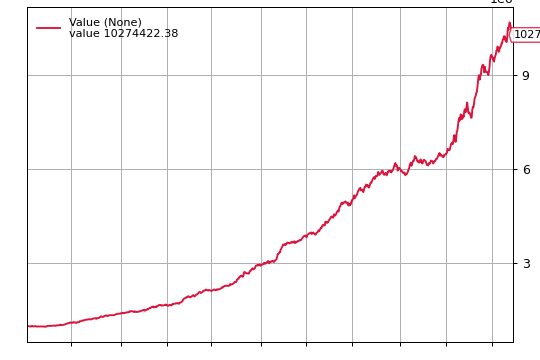

总资金: 10274422.38
净收益: 9274422.38
一共使用时间为:2697.269087791443


In [8]:
##########################
# 主程序开始
##########################


begin_time = time.time()
cerebro = bt.Cerebro(stdstats=False)
# cerebro.broker = bt.brokers.BackBroker(shortcash=True)  # 0.5%
# 考虑印花税和佣金印花税为单边千分之一，佣金设为万五
comminfo = stampDutyCommissionScheme(stamp_duty=0.001, commission=0.0005)
cerebro.broker.addcommissioninfo(comminfo)

for s in stocklist_allA:
    feed = Addmoredata(
        dataname=get_stock_data(s),
        plot=False,
        fromdate=datetime.datetime(2017, 1, 3),
        todate=datetime.datetime(2020, 6, 30),
    )
    cerebro.adddata(feed, name=s)


cerebro.broker.setcash(1000000.0)
# 防止下单时现金不够被拒绝。只在执行时检查现金够不够。
cerebro.broker.set_checksubmit(False)
# 添加相应的费用，杠杆率
# 获取策略运行的指标
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

startcash = 1000000.0
cerebro.addstrategy(momentum_factor_strategy)
cerebro.addobserver(bt.observers.Value)

# 添加Analyzer
cerebro.addanalyzer(
    bt.analyzers.SharpeRatio, riskfreerate=0.01, annualize=True, _name="sharp_ratio"
)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")

thestrats = cerebro.run()
thestrat = thestrats[0]
# 输出分析器结果字典
print("Sharpe Ratio:", thestrat.analyzers.sharp_ratio.get_analysis())
print("DrawDown:", thestrat.analyzers.drawdown.get_analysis())

# 进一步从字典中取出需要的值
print("Sharpe Ratio:", thestrat.analyzers.sharp_ratio.get_analysis()["sharperatio"])
print("Max DrawDown:", thestrat.analyzers.drawdown.get_analysis()["max"]["drawdown"])

# 打印各个分析器内容
for a in thestrat.analyzers:
    a.print()
cerebro.plot()
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
# 打印结果
print(f"总资金: {round(portvalue,2)}")
print(f"净收益: {round(pnl,2)}")
end_time = time.time()
print("一共使用时间为:{}".format(end_time - begin_time))